In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets as mf2_sets
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap
from scipy.signal import find_peaks


In [472]:
seed =10
N = 500
theta_random,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) - np.mean(omega)
dt = 0.1
t_end = 5000
m = 6
K = 1.5
t = np.arange(0,t_end,dt)
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(200))*int(1/dt))
if m == 0:
    dtheta = np.c_[dtheta[0],dtheta.T].T
r_duration = rs[-5000:]
r = np.mean(r_duration)
rstd = np.std(r_duration)
rMM = np.max(r_duration)-np.min(r_duration)
dtheta_c = np.cumsum(dtheta,axis=0)
r_c = np.cumsum(rs,axis=0)
sum_time = 100*int(1/dt)
t_sum = t[sum_time:]
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
avg_r = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [473]:
dtheta.shape

(2000, 500)

In [474]:
temp = avg_dtheta[-1]

In [475]:
def to_cluster_barg(idx,peaks_new):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = np.arange(arg_C[0],arg_C[1])
    return cluster
def to_cstability(x,diff_dtheta):
    try:
        return np.mean(diff_dtheta[x[1:]])
    except IndexError:
        return np.nan
def to_slope(x,SD):
    try:
        return np.polyfit(np.arange(len(x)),SD[x],1)[0]
    except IndexError:
        return np.nan
def to_mean_avg_d_o(x,avg_dtheta,index):
    try:
        return np.mean(avg_dtheta[index][x])
    except IndexError:
        return np.nan

In [476]:
def cluster_os_single(avg_dtheta,N,cidx=False):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_slope(x,SD):
        try:
            return np.polyfit(x,SD[x],1)[0]
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    index = -1
    arg = np.argsort(avg_dtheta[index])
    SD = avg_dtheta[index][arg]
    diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
    peaks, P  = find_peaks(diff_dtheta, height=0.01)

    # peaks = peaks[np.where((peaks<N)&(peaks>1))]

    try:
        peaks_new = np.array([peaks[0],*peaks])
        if len(peaks) == 1:
            peaks_new = np.array([peaks[0],N])

    except IndexError:
        peaks_new = np.array([0,N])


        

    psize = np.diff(peaks_new)
    arg_psize = np.argsort(psize)[::-1]
    sort_psize = np.sort(psize)[::-1]
    clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]

    if len(clusters) == 1:
        clusters = np.array([np.arange(peaks_new[0],N)])
    c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
    c_slope = np.array(list(map(to_slope,clusters,[SD]*len(clusters))))
    mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
    Is_group, = np.where((c_slope<1e-3))
    Is_group

    CM_O = mean_omega[Is_group]
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.sort(psize)[::-1][Is_group][sCM_Oidx]
    C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,c_slope
    else:
        return CM_S,sCM_O

In [477]:
CM_S,sCM_O,C_idx,c_slope = cluster_os_single(avg_dtheta,N,cidx=True)
print(c_slope)

[0.00076901 0.00049983 0.00204285 0.00011596 0.00419884 0.00287703
 0.00420825 0.00382498 0.00537295 0.00197405]


/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/4257303779.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/4257303779.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


(<Figure size 640x200 with 2 Axes>, [<matplotlib.lines.Line2D at 0x16cb66950>])

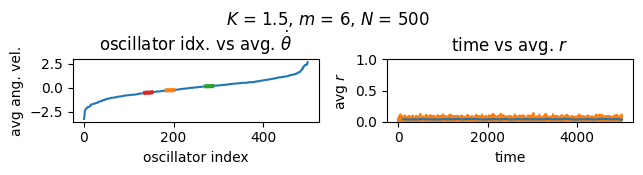

In [478]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx),plt.plot(t,rs,zorder=0)

In [126]:
CM_S,sCM_O,C_idx,check_,psize_array,slope_array =cluster_os(avg_dtheta,N,cidx=True,dt=0.01)
print(check_,CM_S)

0 [ 78. 261.  59.]


/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/4239498861.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


array([ 78., 261.,  59.])

In [130]:
np.mean(psize_array,axis=1)

array([261.        ,  78.        ,  59.        ,  17.        ,
         7.04333333,   5.35666667,   5.        ,   5.        ,
         5.        ,   4.89333333])

In [135]:
np.min(slope_array,axis = 1)

array([-0.00012627, -0.00026197, -0.00018715, -0.0001791 , -0.00034489,
       -0.00037505, -0.00037776, -0.00037776, -0.00037776, -0.00040207])

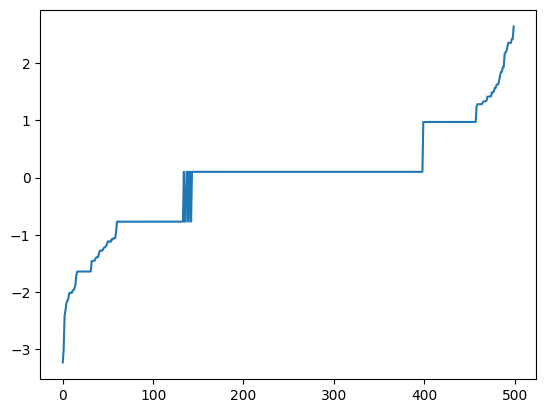

In [132]:
plt.plot(avg_dtheta[-1])

ValueError: x and y can be no greater than 2D, but have shapes (20000,) and (20000, 10, 1)

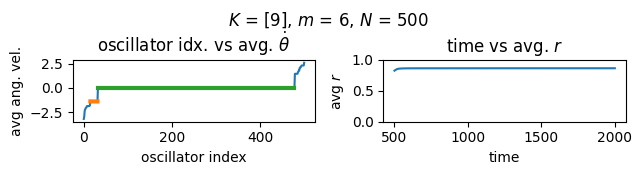

In [93]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx),plt.plot(t,rs,zorder=0)

In [32]:
K_set = np.arange(0,10,0.5).reshape(-1,1)
seed = 10
m = 0
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
omega_sets = (np.ones((N_set,1))*omega)


m = 0
t_end = 2000
dt =0.1
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets(K_set,N=N,m=m,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-300)*(1/dt)))
if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)

In [33]:
dtheta_set.shape

(3000, 20, 500)

In [34]:
dtheta_set[::10]

array([[[-3.23541133, -3.01060676, -2.426582  , ...,  2.43431509,
          2.43664107,  2.64890032],
        [-3.22701656, -2.99426943, -2.44624988, ...,  2.45358746,
          2.45325328,  2.62817854],
        [-3.27934501, -3.08083525, -2.40741096, ...,  2.38537966,
          2.43562409,  2.61243581],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-3.23541133, -3.01060676, -2.426582  , ...,  2.43431509,
          2.43664107,  2.64890032],
        [-3.25554893, -3.03346122, -2.42941751, ...,  2.42011243,
          2.41366541,  2.67128178],
        [-3.1523566 , -2.90223797, -2.35413439, ...,  2.54256534,
          2.52461186,  2.61025043],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [42]:
sum_time = 500*int(1/dt)
def to_avg(dtheta,sum_time=100*int(1/dt)):
    dtheta_c = np.cumsum(dtheta,axis=0)
    avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    return avg_dtheta
avg_dtheta_set = to_avg(dtheta_set,sum_time = sum_time)

In [22]:
r_c = np.cumsum(rs.T[0].T,axis=0)
sum_time = 50*int(1/dt)
t_sum = t[sum_time:]
avg_r_set = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [34]:
r_duration = rs[-5000:,:]
r = np.mean(r_duration,axis=0).reshape(-1)
rstd = np.std(r_duration,axis=0).reshape(-1)
rMM = np.max(r_duration)-np.min(r_duration)

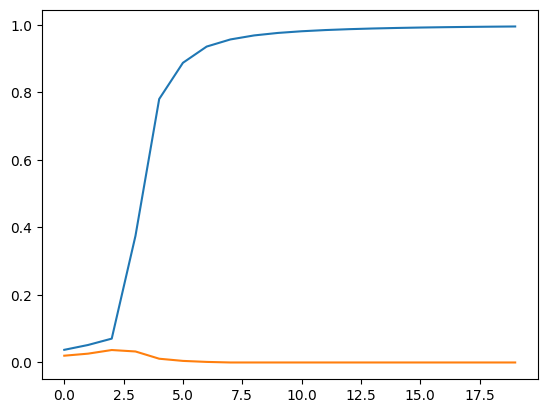

In [36]:
plt.plot(r)
plt.plot(rstd)

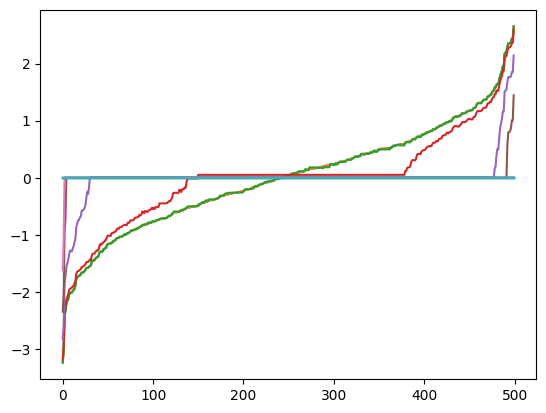

In [23]:
plt.plot(avg_dtheta_set[-1].T);

In [449]:
rs.shape

(20000, 20, 1)

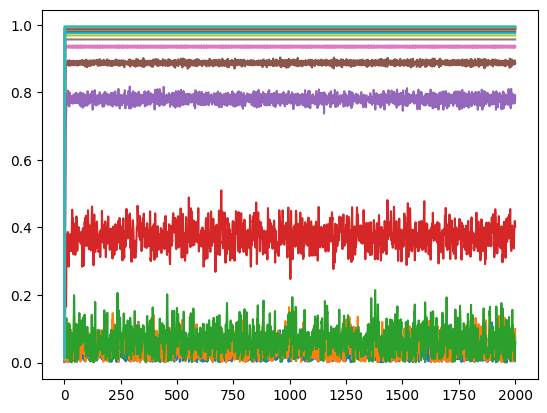

In [24]:
r = rs.T[0].T
plt.plot(t,r)

In [257]:
np.polyfit([1,2,3],[1,1,1,],1)[0]

-8.185332456055529e-17

In [25]:
def cluster_os(avg_dtheta,N,cidx=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 1000
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
            if len(peaks) == 1:
                peaks_new = np.array([peaks[0],N])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    mm = np.max(psize_array,axis=1) - np.min(psize_array,axis=1)
    # Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))
    Is_group, = np.where((mm <= 1)&(psize_array[:,-1]>3))
    check_ = 0
    min_group_s = np.min(c_stability_array,axis=1)
    max_group_s = np.max(c_stability_array,axis=1)
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((min_group_s<5e-4)&(psize_array[:,-1]>3))
    Is_group3, = np.where((max_group_s<2e-3))
    Is_group = np.intersect1d(np.intersect1d(Is_group,Is_group2),Is_group3)
    if len(Is_group)==0:
        check_ = 1
        # Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))
        Is_group, = np.where((min_group_s<1e-5)&(mm <= 1)&(psize_array[:,-1]>3))

    # if len(Is_group)==0:
    #     check_ = 2
    #     mean_group_s = np.mean(c_stability_array,axis=1)
    #     Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,check_,psize_array
    else:
        return CM_S,sCM_O,check_

In [479]:
def cluster_os(avg_dtheta,N,cidx=False,p_array=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 200
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
            if len(peaks) == 1:
                peaks_new = np.array([peaks[0],N])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>3))
    check = 0
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((mean_group_s<6e-4)&(psize_array[:,-1]>3))
    Is_group = np.intersect1d(Is_group,Is_group2)
    if len(Is_group)==0:
        check = 1
        mm = np.max(psize_array,axis=1) - np.min(psize_array,axis=1)
        # Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))
        Is_group, = np.where((c_stability<5e-4)&(mm <= 1))

    # if len(Is_group)==0:
    #     check = 2
    #     mean_group_s = np.mean(c_stability_array,axis=1)
    #     Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,check,psize_array
    if p_array == True:
        return CM_S,sCM_O,C_idx,check,psize_array
    else:
        return CM_S,sCM_O,check

In [ ]:
for i in range(N_set):
    avg_dtheta = avg_dtheta_set[:,i]
    CM_S,sCM_O,C_idx,check_ =cluster_os_single(avg_dtheta,N,cidx=True)
    line_ = [np.polyfit(c_idx,avg_dtheta[-1][c_idx],1)[0] for c_idx in C_idx]
    K = K_set[i]
    avg_r = avg_r_set.T[i]
    r = rs.T[0][i]
    print(K,check_,len(line_))
    Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx)
    plt.plot(t,r,zorder=0)

In [ ]:
for i in range(N_set):
    avg_dtheta = avg_dtheta_set[:,i]
    CM_S,sCM_O,C_idx,check_,psize_array =cluster_os(avg_dtheta,N,cidx=True,dt=0.01)
    line_ = [np.polyfit(c_idx,avg_dtheta[-1][c_idx],1)[0] for c_idx in C_idx]
    K = K_set[i]
    avg_r = avg_r_set.T[i]
    r = rs.T[0][i]
    print(K,check_,len(line_))
    Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx)
    plt.plot(t,r,zorder=0)

In [40]:
avg_dtheta_set.shape

(1999, 20, 500)

In [38]:
cluster_os(avg_dtheta=avg_dtheta,N=N,dt=dt)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [263]:
K_set.reshape(-1)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

4.0


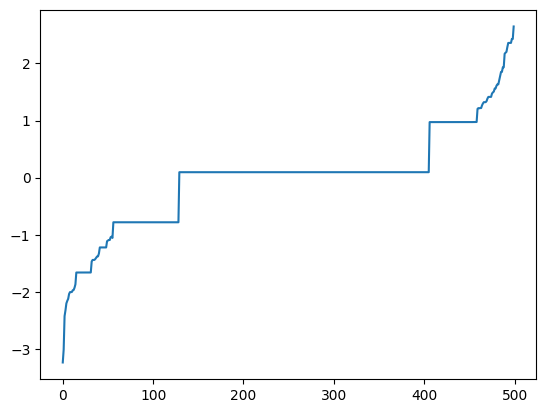

In [267]:
i =8
print(K_set.reshape(-1)[i])
plt.plot(avg_dtheta_set[:,7][-1])

## 새로 만든 알고리즘에서 작은 크기의 클러스터는 확인을 잘 하지 못함.
> 기존의 클러스터를 확인하는 알고리즘이 좀 더 좋은 성능과 일관된 결과를 주는 것 같아  
> 클러스터를 개선만 시켜서 사용함

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets as mf2_sets
from TO_sim.get_cluster import C_rsmso,cluster_os,C_rsmso_set
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap
from scipy.signal import find_peaks
from TO_sim.To_Draw import Draw_avg_vel_r


In [1563]:
def cluster_os(avg_dtheta,N,cidx=False,p_array=False,dt=0.1,peak_height = 0.03,first_sensitivity=3e-3,second_sensitivity = 4e-3):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 1500
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=peak_height)
        # peaks,  = np.where(diff_dtheta>1e-3)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
            if len(peaks) == 1:
                peaks_new = np.array([peaks[0],N])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]

        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]

        except ValueError:
            pass
            

    Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>5))
    Is_group3, = np.where((np.std(psize_array,axis=1) == 0))
    check = 0
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((mean_group_s<first_sensitivity)&(psize_array[:,-1]>5))
    Is_group = np.intersect1d(Is_group,Is_group2)
    if len(Is_group)==0:
        check = 1
        mm = np.max(psize_array,axis=1) - np.min(psize_array,axis=1)
        Is_group, = np.where((mean_group_s<second_sensitivity)&(psize_array[:,-1]>5))
        Is_group2, = np.where((mm <= 2)&(psize_array[:,-1]>5))
        Is_group = np.intersect1d(Is_group,Is_group2)

    # if len(Is_group)==0:
    #     check = 2
    #     mean_group_s = np.mean(c_stability_array,axis=1)
    #     Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    # CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    CM_S = np.mean(psize_array[Is_group],axis=1)
    C_idx = np.array([arg[i] for i in clusters[Is_group]])

    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[Is_group]])
        return CM_S,CM_O,C_idx,check,psize_array,cluster_array,Is_group3
    if p_array == True:
        return CM_S,CM_O,C_idx,check,psize_array
    else:
        return CM_S,CM_O,C_idx,check

In [16]:
1%10

1

In [35]:
def C_rsmso_set(m,K_set,N,theta_init_set,omega_set,pdtheta_set,t_end=5000,dt=0.1):
    t = np.arange(0,t_end,dt)
    _, dtheta_set,rs = mf2_sets(K_set,m=m,N=N,t_array=t,
                                p_theta=theta_init_set,p_dtheta= pdtheta_set,p_omega=omega_set,
                                result_time = int((t_end)-(200))*int(1/dt)-(150)*int(1/dt))
    if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)
    N_set = len(theta_init_set)
    r_duration = rs[-5000:,:]
    r = np.mean(r_duration,axis=0).reshape(-1)
    rstd = np.std(r_duration,axis=0).reshape(-1)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0)).reshape(-1)

    sum_time = 200*int(1/dt)
    if dt == 0.01:
        sum_time = 2000
    dtheta_c = np.cumsum(dtheta_set,axis=0)
    avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    CSO_set = []
    check_set = [] 
    for i in range(N_set):
        CM_S,CM_O,check = cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt)
        CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
        CSO_set.append(CSO)
        check_set.append(check)
    return r,rstd,rMM,CSO_set,check_set,avg_dtheta_set[-1]

## **simulation**

In [3]:
K_set = np.arange(0,10,0.1).reshape(-1,1)
seed = 11
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
# theta_sets = (np.ones((N_set,1))*np.ones_like(theta_init))
omega_sets = (np.ones((N_set,1))*omega)


m = 10
t_end = 2000
dt =0.1
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets(K_set,N=N,m=m,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-350)*(1/dt)))
if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)

In [5]:
sum_time = 1500
dtheta_c = np.cumsum(dtheta_set,axis=0)
avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

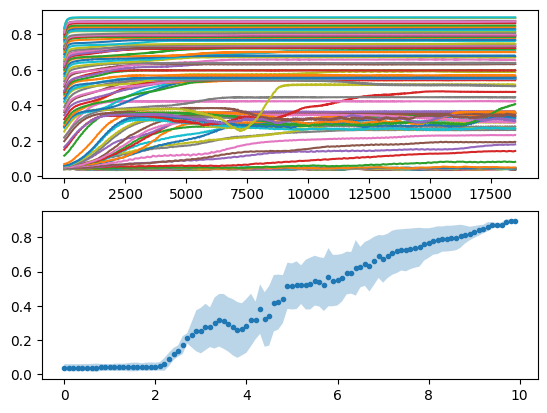

In [6]:
r_c = np.cumsum(rs.T[0].T,axis=0)
sum_time = 150*int(1/dt)
t_sum = t[sum_time:]
avg_r_set = (r_c[sum_time:]-r_c[:-sum_time])/sum_time
plt.subplot(211)
plt.plot(avg_r_set,label=K_set);
plt.subplot(212)
Ks = K_set.reshape(-1)
mean_rs = np.mean(avg_r_set,axis=0)
mean_rs_std = np.std(rs.T[0].T[-sum_time:],axis=0)
plt.plot(Ks,mean_rs,'.')
plt.fill_between(Ks,mean_rs-mean_rs_std,mean_rs+mean_rs_std,alpha=0.3)
# plt.legend()

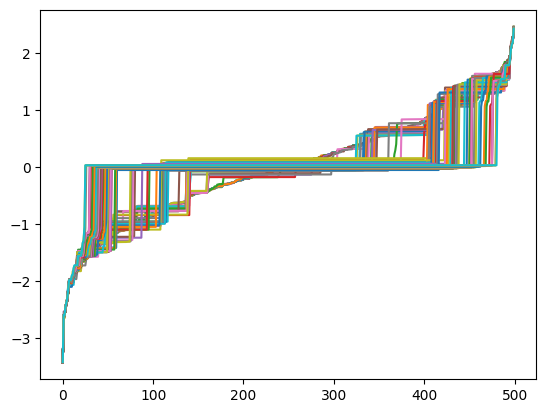

In [7]:
plt.plot(np.sort(avg_dtheta_set[-1].T,axis=0));

In [3350]:
dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
CSO_set = []
check_set = [] 
cluster_set = []
Is_group_set = []
for i in range(N_set):
    CM_S,sCM_O,C_idx,check= cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt,peak_height = 3e-2,first_sensitivity=3e-3,second_sensitivity = 4e-3,cidx=False)
    # CM_S,sCM_O,C_idx,check,psize_array,cluster_array,Is_group= cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt,peak_height = 0.03,first_sensitivity=3e-3,second_sensitivity = 4e-3,cidx=True)
    CSO = np.array([(S,O) for S,O in zip(CM_S,sCM_O)],dtype=dtype)
    CSO_set.append(CSO)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


start 1.5


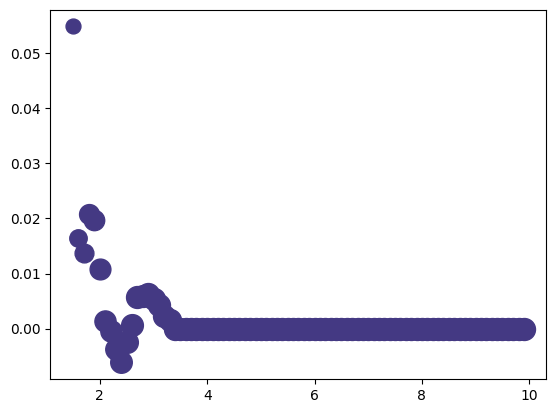

In [3352]:
num = 0 
for K,CSO in zip(K_set.reshape(-1),CSO_set):
    if (len(CSO) > 0)&(num==0):
        num +=1
        start_K = K
        print('start',K)
    x = CSO['cluster mean phase velocity']
    s = CSO['cluster size']
    if (K>2)&(len(s)==0):
        print('non',K)
    plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=6)

In [921]:
df = pd.read_excel('N = 500 seed = 10 test 230627.xlsm',index_col=[0,1])
ms = df.reset_index().m.unique()

0.0 [2.2 2.3 2.6]
0.1 [2.1 2.6]
0.2 [2.2 2.6]
0.3 [2.5 2.6]
0.4 [2.7 3.5]
0.5 [2.9]
0.6000000000000001 [3.1]
1.3 [5.2]
1.5 [5.]
1.6 [2.1 6.2]
1.7 [2.1 2.2 2.3]
1.8 [2.2 6.9]
1.9 [2.1]
2.0 [2.9]
2.2 [2.5]
2.3 [2.3 2.5]
2.4 [3.6]
2.6 [2.4 3.4]
2.7 [2.2 2.5 2.6 3.5 5.1]
2.8 [2.6]
2.9 [3.3 5.3]
3.1 [2.3 2.4]
3.2 [2.7 4.8 9.8]
3.3 [5.6]
3.5 [3.  5.9]
3.7 [2.7 3.6 4.  4.1]
3.8 [2.1 2.7 3.3 3.6 3.9 4.9]
3.9 [2.5 2.9]
4.0 [3.3 3.7 6.9]
4.100000000000001 [2.4]
4.2 [2.3]
4.3 [2.1 2.5 3.2 3.3]
4.4 [3.4 3.6 4.5 5.6 8. ]
4.5 [2.7 3.  4.6]
4.600000000000001 [2.3 2.7 6. ]
4.7 [2.5 2.6 3.3]
4.800000000000001 [2.3 2.6 3.4 3.9 7.8]
4.9 [2.1 2.9 3.4 7.6]
5.0 [2.2 9.2]
5.100000000000001 [2.8 3.5 5.7]
5.2 [3.  7.2]
5.300000000000001 [2.3 2.7 3.1]
5.4 [3.1 3.6]
5.5 [2.5]
5.7 [2.4 6.9]
5.800000000000001 [2.4 7.7]
5.9 [2.4 2.9 4.2]
6.0 [2.9 3.1]
6.100000000000001 [2.5 2.8 3.1]
6.2 [2.7]
6.300000000000001 [3.]
6.4 [2.5]
6.5 [2.2 3.1]
6.600000000000001 [2.3]
7.0 [2.4 2.8 3.2]
7.100000000000001 [2.7]
7.2 [2.3 2.

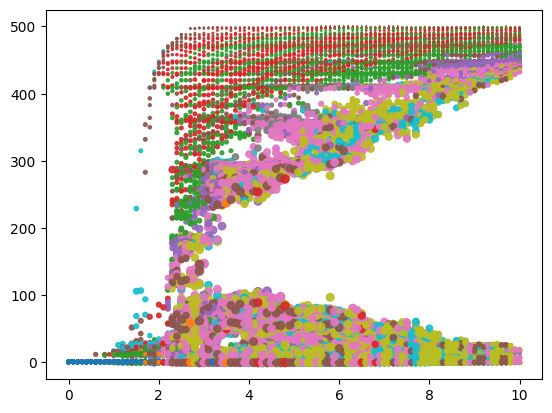

In [939]:
for i in range(100):
    ms = df.reset_index().m.unique()
    re_df = df.reset_index()

    df_m = re_df[re_df.m == ms[i]]
    Ks = df_m.K.to_numpy()
    rs = df_m.r.to_numpy()
    rstd = df_m.rstd.to_numpy()
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]

    len_cluster = (~cluster_o.isna()).sum(axis=1).to_numpy()
    plt.scatter(np.ones((10,101))*Ks,cluster_s.to_numpy().T,alpha=0.9,
                c=np.ones((10,101))*(len_cluster),s=50*np.ones((10,101))*rMM,cmap='tab10')
    # plt.colorbar()
    len_cluster = (~cluster_o.isna()).sum(axis=1)
    is_na = df_m.K.loc[df_m.K>2][len_cluster ==0].to_numpy()
    if len(is_na) !=0:
        print(ms[i],is_na)


In [934]:
Ks

Series([], Name: K, dtype: float64)

In [ ]:
df_m.K.loc[df_m.K>2][len_cluster ==0]

0


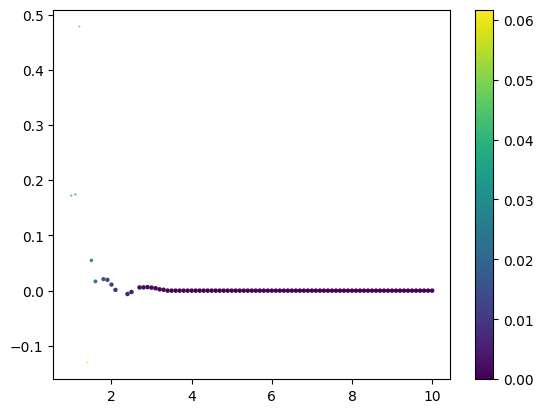

In [2249]:
re_df = df.reset_index()
df_m = re_df[re_df.m == 0]
Ks = df_m.K
rs = df_m.r
rMM= df_m.rMM.to_numpy()
rstd= df_m.rstd.to_numpy()
cluster_s = df_m.iloc[:,5:15]
cluster_o = df_m.iloc[:,15:25]
print(len(cluster_s['c1'].dropna()))
plt.scatter(np.ones((10,101))*Ks.to_numpy(),(cluster_o.to_numpy().T),c=np.ones((10,101))*rstd,
            s=0.01*cluster_s.to_numpy().T)
plt.colorbar()

In [ ]:
Ks

In [ ]:
for i in range(81,91):
    m_idx = i
    ms = df.reset_index().m.unique()
    re_df = df.reset_index()

    df_m = re_df[re_df.m == ms[m_idx]]
    Ks = df_m.K
    rs = df_m.r
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]
    print(len(cluster_s['c1'].dropna()))
    plt.scatter(np.ones((10,100))*Ks.to_numpy(),(cluster_o.to_numpy().T),c=cluster_s.to_numpy().T,alpha=0.5,
                s=50*np.ones((10,100))*rstd)
plt.colorbar()

In [2347]:
%timeit CM_S,sCM_O,C_idx,check= cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt,peak_height = 3e-2,first_sensitivity=3e-3,second_sensitivity = 4e-3,cidx=False)


502 ms ± 78.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


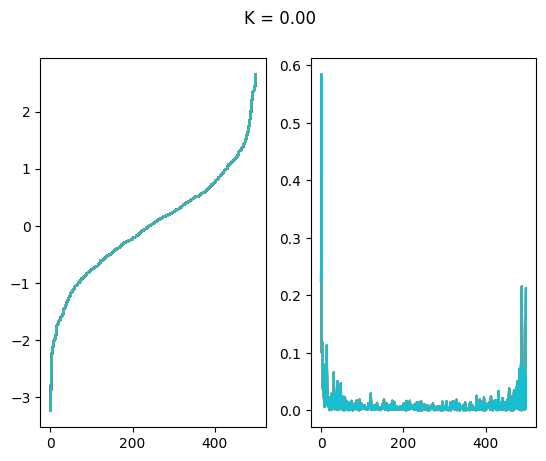

In [3124]:
K_ = 0
K_want = np.searchsorted(K_set.reshape(-1),K_)

# group = Is_group_set[K_want]
plt.subplot(121)
plt.plot(np.sort(avg_dtheta_set[-100:,K_want]).T);
plt.subplot(122)
plt.plot(np.diff(np.sort(avg_dtheta_set[-10:,K_want]),axis=1).T)
plt.suptitle(f'K = {K_set.reshape(-1)[K_want]:.2f}')

AVG = avg_dtheta_set[-1500:,K_want]
sort_avg = np.sort(AVG,axis=1)
sort_argavg = np.argsort(AVG,axis=1)
diff_avg = np.diff(np.c_[sort_avg[:,0],sort_avg],axis=1)


(0.0, 0.036)

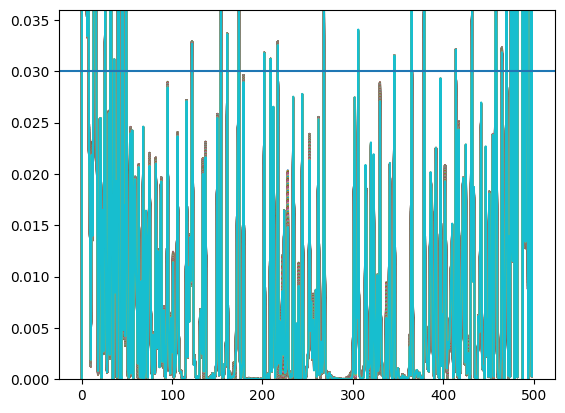

In [3091]:
plt.plot(diff_avg[-100:].T)
h = 3e-2
plt.axhline(h)
plt.ylim(0,h*1.2)

In [3092]:
def peaks_(x,h=1e-3,s = 3):
    A, = np.where(x>h)
    A = np.r_[A[0],A,N]
    A_ = np.diff(A)
    diff_A = A_[A_>s]
    sort_ = np.sort(diff_A)[::-1]
    return diff_A
def map_arg(x,arg):
    return x[arg]
temp = np.array([peaks_(x,1e-2) for x in diff_avg[:1500]])
len_min = np.argmin(list(map(len,temp)))
arg = np.argsort(temp[len_min])[::-1]
temp = np.array([map_arg(x,arg) for x in temp])

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_21503/1722017665.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array([peaks_(x,1e-2) for x in diff_avg[:1500]])


In [9]:
def peaks_(x,h=1e-3,N=N):
    A, = np.where(x>h)
    A =  np.r_[0,A,N]
    diff_A = np.diff(A)
    sort_ = np.sort(diff_A)[::-1][:10]
    argsort_ = np.argsort(diff_A)[::-1]
    C_start = A[argsort_][:10]
    C_end = A[argsort_+1][:10]
    return sort_,C_start,C_end
# AVG = avg_dtheta_set[-1500:,K_want]

def cluster_os_new2(AVG,height=1e-2,c_std = 3,check=2e-4,c_size=3,N=N,omega=omega):
    num = 0
    C_size = []
    C_start = []
    C_end = []
    sort_avg = np.sort(AVG,axis=1)
    sort_argavg = np.argsort(AVG,axis=1)
    diff_avg = np.diff(np.c_[sort_avg[:,0],sort_avg],axis=1)
    for A,c_start,c_end in [peaks_(x,height,N=N) for x in diff_avg]:
        # C_size.append(A)
        # C_start.append(c_start)
        # C_end.append(c_end)
        if num == 0:
            C_size.append(A)
            num+=1
            C_size = A
            C_start = c_start
            C_end = c_end
        else:
            C_size = np.c_[C_size,A]
            C_start = np.c_[C_start,c_start]
            C_end = np.c_[C_end,c_end]
    Is_group, = np.where((np.std(C_start,axis=1)<c_std)&(A>c_size))
    arg = sort_argavg[-1]

    cluster = np.array([np.arange(c_i,c_j,1) for c_i,c_j in zip(C_start[Is_group,-1],C_end[Is_group,-1])])
    check_ = [np.mean(diff_avg[-1,c_[1:]])<check for c_ in cluster]
    cluster = cluster[check_]
    C_s,C_e = [],[]
    CMO = []
    for c_ in cluster:
        c_s = np.min(arg[c_])
        c_e = np.max(arg[c_])
        C_s.append(c_s)
        C_e.append(c_e)
        mean_omega = np.mean(omega[c_s:c_e])
        CMO.append(mean_omega)
    Is_group = Is_group[check_]
    omega_s = [omega[c_s] for c_s in C_s]
    omega_e = [omega[c_e-1] for c_e in C_e]
    CMP = np.array([np.mean(sort_avg[0,c_]) for c_ in cluster])
    CS = np.array([len(c_) for c_ in cluster])
    return CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e


# print(np.std(A,axis=0))
# A_minmax = np.max(A,axis=0) - np.min(A,axis=0)
# print(A_minmax)

In [3204]:
C_end[Is_group,-1]

array([], dtype=int64)

In [3150]:
cluster_os_new2(AVG,check=2e-1)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_21503/1398359352.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster = np.array([np.arange(c_i,c_j,1) for c_i,c_j in zip(C_start[Is_group,-1],C_end[Is_group,-1])])


(array([ 0.02330043, -1.47937314,  1.52668224]),
 array([428,  24,   9]),
 array([array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
                52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
                65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
                78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
                91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
               104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
               117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
               130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
               143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
               156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
               169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
               182, 183, 184, 185, 186, 187, 1

In [3362]:
height=1e-2
c_std = 3
num = 0
C_size = []
C_start = []
C_end = []
sort_avg = np.sort(AVG,axis=1)
sort_argavg = np.argsort(AVG,axis=1)
diff_avg = np.diff(np.c_[sort_avg[:,0],sort_avg],axis=1)
for A,c_start,c_end in [peaks_(x,height) for x in diff_avg]:
    if num == 0:
        num+=1
        C_size = A
        C_start = c_start
        C_end = c_end
    else:
        C_size = np.c_[C_size,A]
        C_start = np.c_[C_start,c_start]
        C_end = np.c_[C_end,c_end]
Is_group, = np.where(np.std(C_start,axis=1)<c_std)
arg = sort_argavg[-1]

cluster = np.array([np.arange(c_i,c_j,1) for c_i,c_j in zip(C_start[Is_group,-1],C_end[Is_group,-1])])
check_ = [np.mean(diff_avg[-1,c_[1:]])<1e-4 for c_ in cluster]
cluster = cluster[check_]
Is_group = Is_group[check_]
omega_s = [omega[c_i] for c_i in C_start[Is_group,-1]]
omega_e = [omega[c_e] for c_e in C_end[Is_group,-1]]
CMP = np.array([np.mean(sort_avg[0,c_]) for c_ in cluster])
CS = C_size[Is_group,-1]
omega_ss = [np.sort(omega[arg[c_]]) for c_ in cluster]

IndexError: index 500 is out of bounds for axis 0 with size 500

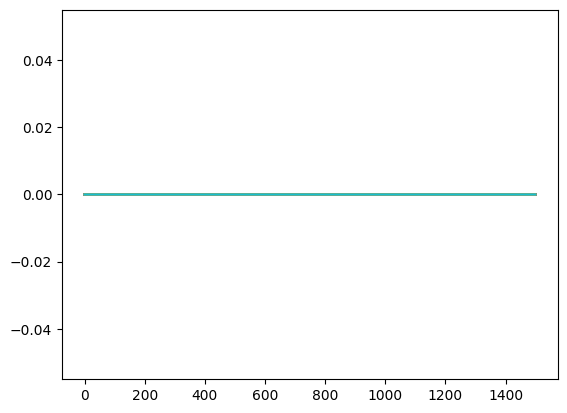

In [3363]:
plt.plot(diff_avg)

In [3364]:
[peaks_(x,height) for x in diff_avg]

[(array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([500]), array([0]), array([500])),
 (array([50

In [3110]:
C_size[IS_group,-1]

array([13])

In [3106]:
%timeit cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt,peak_height = 3e-2,first_sensitivity=3e-3,second_sensitivity = 4e-3,cidx=False)


/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_21503/3720339713.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[Is_group]])


482 ms ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3104]:
%timeit cluster_os_new2(AVG,height=1e-2)

65.5 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


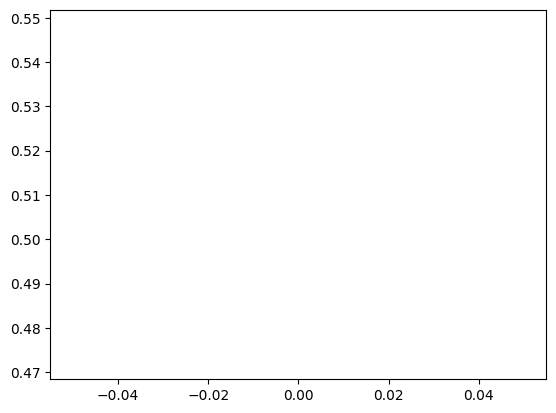

In [3094]:
plt.plot(omega_s)
plt.plot(omega_e)
# for o in omega_ss:plt.plot(o)

False


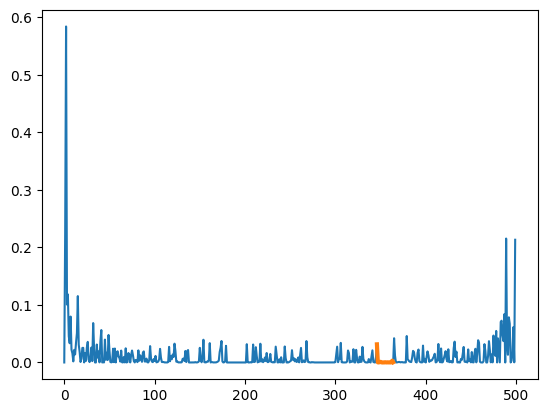

In [3095]:
plt.plot(diff_avg[-1])
for idx in cluster:
    plt.plot(idx[:],diff_avg[-1,idx[:]],lw=3)
    print(np.mean(diff_avg[-1,idx[1:]])<1e-4)

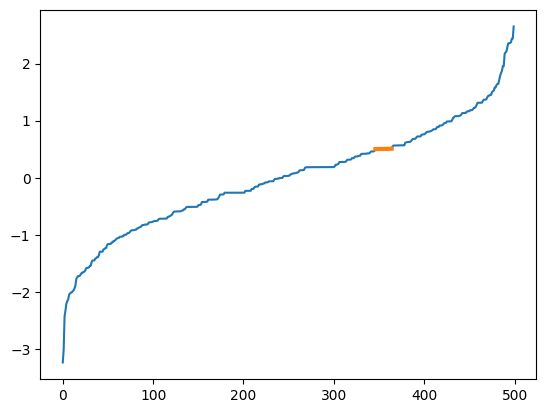

In [3096]:
plt.plot(sort_avg[-1])
for idx in cluster:
    plt.plot(idx,sort_avg[-1,idx],lw=3)

In [2836]:
np.std(C_start,axis=1)

array([  0.58581908,   0.        ,   0.48152351,   5.68321114,
         5.68321114,  72.49385816, 205.79121839, 213.93001659,
       222.26911745, 220.07159227])

 ...]

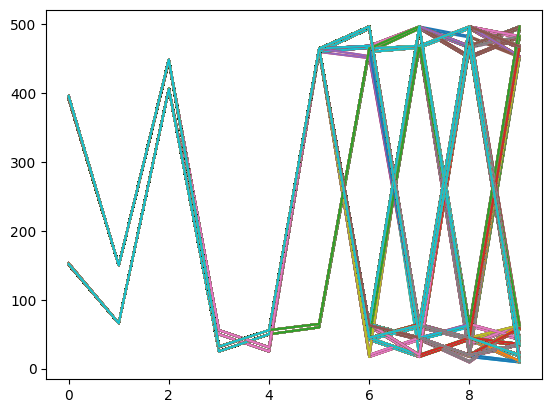

In [2837]:
plt.plot(C_start)
plt.plot(C_end)

In [2636]:
C_size[Is_group,:]

array([[14, 14, 14, ..., 14, 14, 14],
       [10, 10, 10, ..., 10, 10, 10]])

 ...]

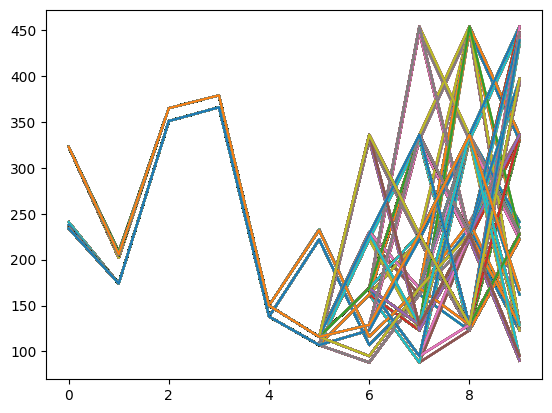

In [2614]:
plt.plot(C_start)
plt.plot(C_end)

In [2574]:
C_start.shape

(10, 1501)

In [2615]:
np.unique(C_start[1]),np.unique(C_start[2])

(array([174]), array([351]))

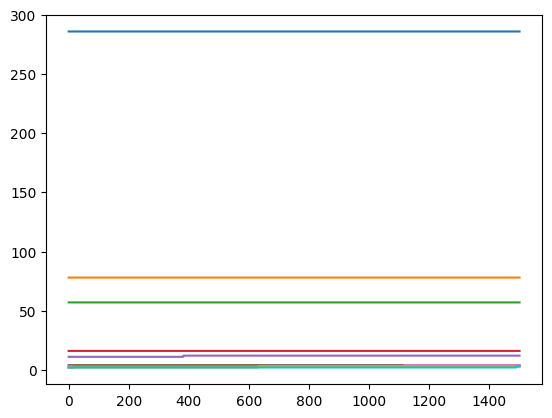

In [2734]:
plt.plot(np.sort(C_size,axis=1).T)

In [ ]:
plt.plot()

In [2551]:
Is_group, = np.where(np.std(C_start,axis=1)==0)
print(Is_group)

[0]


In [2552]:
np.std(C_start.T,axis=0),np.std(C_end.T,axis=0)

(array([  0.        ,  47.73126478,  82.30237577, 128.74984324,
         78.82347921, 128.22335178, 137.40811706,  75.51218585,
        179.5350363 ,  75.44470518]),
 array([  0.        ,  43.41465294,  81.28700977, 137.17182898,
         78.56442853, 128.548116  , 138.21936494,  75.00292087,
        181.20609465,  75.91394282]))

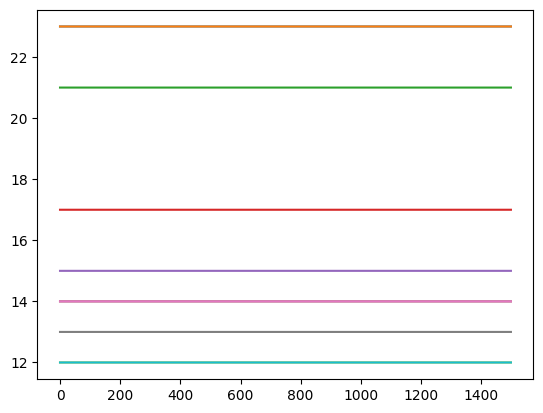

In [3237]:
plt.plot(C_size.T)

In [2540]:
IS_group

array([0, 2])

In [2541]:
Is_group

array([0])

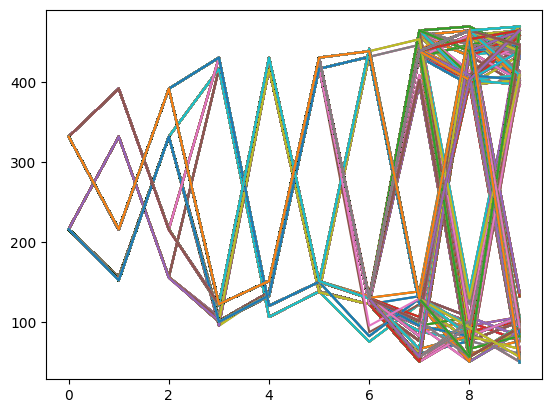

In [2542]:
plt.plot(C_start);
plt.plot(C_end);

In [2394]:
IS_group

array([], dtype=int64)

In [2346]:
%timeit [peaks_(x,3e-3) for x in diff_avg[:1500]]

14.1 ms ± 641 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2330]:
A, = np.where(diff_avg[0]>3e-2)
A = np.r_[A,N]
diff_A = np.diff(A)
sort_ = np.sort(diff_A)[::-1]
argsort_ = np.argsort(diff_A)[::-1]
C_start = A[argsort_]
C_end = A[argsort_+1] 

In [2332]:
list(zip(C_start,C_end))

[(2, 500), (1, 2)]

In [2313]:

A[Argsort_]

array([2, 1, 1])

In [2310]:
diff_avg>3e-3

array([[False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])

In [2307]:
diff_avg

array([[0.00000000e+00, 4.51128167e-01, 1.34736743e+00, ...,
        1.54589190e-06, 4.87595474e-06, 5.31495959e-06],
       [0.00000000e+00, 4.51496724e-01, 1.34636085e+00, ...,
        1.47802022e-06, 4.75217608e-06, 5.33928394e-06],
       [0.00000000e+00, 4.51357630e-01, 1.34560515e+00, ...,
        1.40500396e-06, 4.59833858e-06, 5.31125940e-06],
       ...,
       [0.00000000e+00, 4.56681809e-01, 1.34340476e+00, ...,
        6.04572738e-07, 2.32024651e-08, 8.36255463e-07],
       [0.00000000e+00, 4.56630649e-01, 1.34335554e+00, ...,
        6.80720294e-07, 2.66874993e-08, 1.56707601e-06],
       [0.00000000e+00, 4.56514902e-01, 1.34333727e+00, ...,
        7.48442464e-07, 2.98246087e-08, 2.26685579e-06]])

In [2306]:
IS_group

(array([0, 1, 2]),)

In [ ]:
np.where(A)

In [2303]:
print(A)

[[498   1]
 [498   1]
 [498   1]
 ...
 [498   1]
 [498   1]
 [498   1]]


In [2186]:
np.r_[1,[1,2,3]]

array([1, 1, 2, 3])

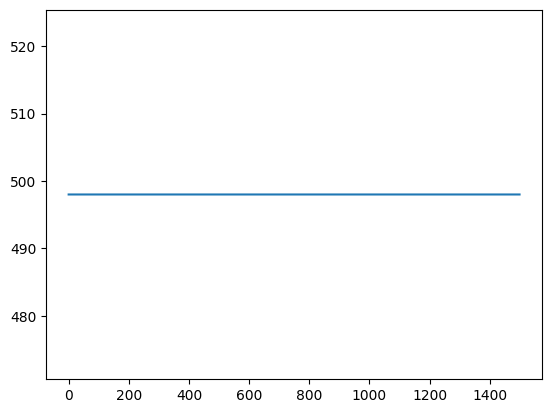

In [2294]:
plt.plot(temp)

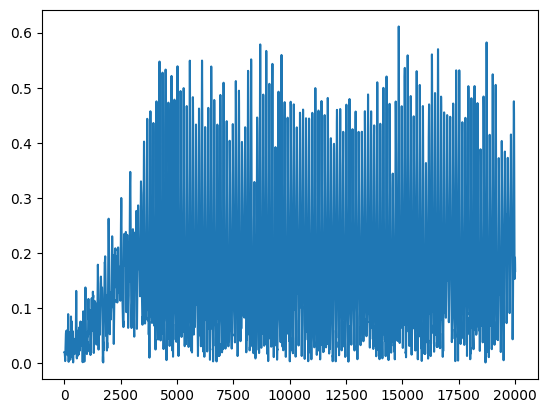

In [2184]:
plt.plot(rs.T[0][K_want])

In [2098]:
A_minmax

array([5, 4, 3, 5, 6, 5, 4, 3, 2, 2])

In [2027]:
psize = np.array([peaks_(x,3e-2) for x in diff_avg[:1500]])

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_21503/905940736.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  psize = np.array([peaks_(x,3e-2) for x in diff_avg[:1500]])


In [1991]:
list(map(np.bincount, psize.T))

[array([   0,    0, 1500]),
 array([   0,    0, 1500]),
 array([  0, 802, 698]),
 array([   0, 1216,  284]),
 array([   0, 1357,  143]),
 array([   0, 1500]),
 array([   0, 1500]),
 array([   0, 1500]),
 array([   0, 1500]),
 array([   0, 1500])]

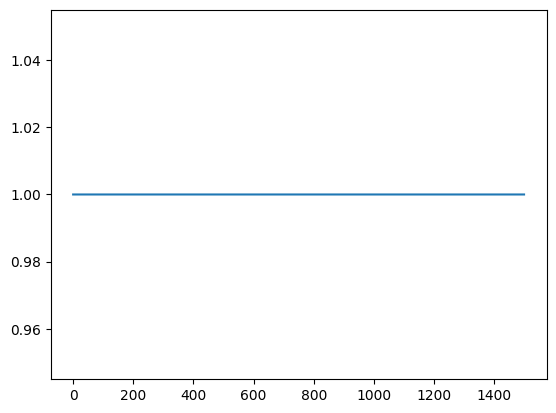

In [2275]:
plt.plot([peaks_(x,3e-2) for x in diff_avg[:1500]])

 ...]

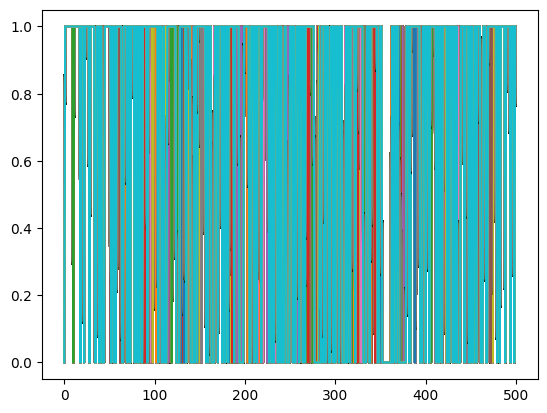

In [1729]:
plt.plot(np.where(diff_avg<1e-3,0,1).T)

In [1712]:
diff_avg.shape

(1500, 500)

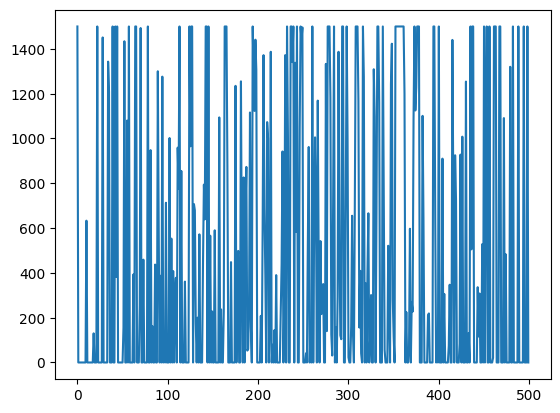

In [1717]:
plt.plot(np.sum(diff_avg.T<1e-3,axis=1))

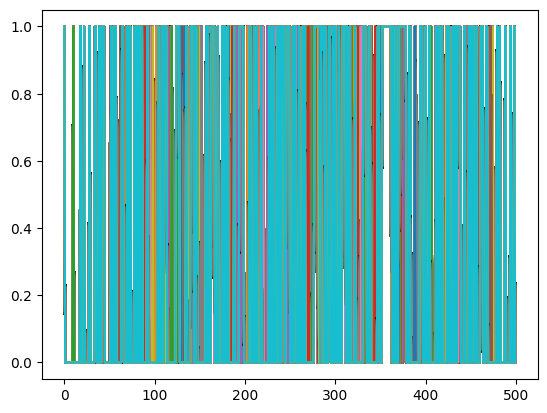

In [1710]:
plt.plot(diff_avg.T<1e-3);

 ...]

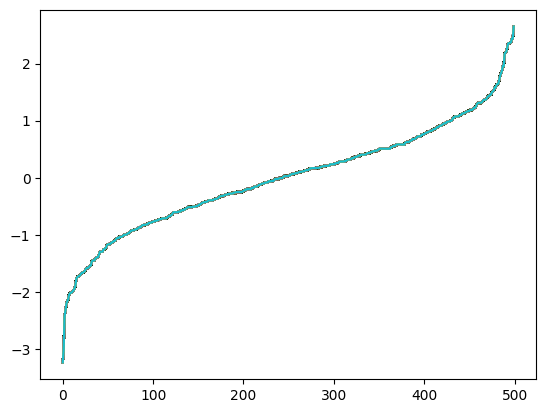

In [1702]:
plt.plot(AVG.T)

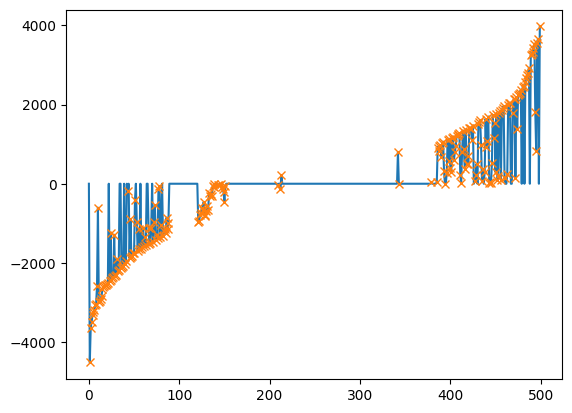

In [2080]:
A = []
avg_dtheta = avg_dtheta_set[-1500:,K_want]
threshold = 15e-4
for i in range(1500):
    arg = np.argsort(avg_dtheta[-i])
    temp = avg_dtheta[-i]
    temp = np.where(np.diff([temp[arg][0],*temp[arg]])
                    <threshold,0,temp[arg])
    A.append(temp)
mean_A_index = np.where(np.sum(A,axis=0) ==  0,0,np.sum(A,axis=0)) #실제 클러스터의 값

def to_cluster_barg(idx,peaks_new):
   C = idx,idx+1
   arg_C = peaks_new[C[0]],peaks_new[C[1]]
   cluster = np.arange(arg_C[0],arg_C[1])
   return cluster
diff_avg_dtheta = np.diff(np.c_[avg_dtheta[:,arg[0]],avg_dtheta[:,arg]],axis=1)
plt.plot(mean_A_index)
peaks, =  np.where(np.sum(A,axis=0) !=  0)

plt.plot(peaks,mean_A_index[peaks],'x')


# peaks = peaks[np.where((peaks<N)&(peaks>1))]
# 
try:
    peaks_new = np.array([peaks[0],*peaks,N])
    if len(peaks) == 1:
        peaks_new = np.array([peaks[0],N])
except IndexError:
    peaks_new = np.array([0,N])

psize = np.diff(peaks_new)
arg_psize = np.argsort(psize)[::-1]
sort_psize = np.sort(psize)[::-1]
clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
c_size = np.array(list(map(len,clusters)))
c_stability = []
c_std = []
mean_omega = []
for c_ in clusters:
    c_stability.append(np.mean(diff_avg_dtheta[:,c_[1:]])/len(c_))
    c_std.append(np.mean(np.diff(avg_dtheta[:,arg[c_[:]]],axis=1)))
    mean_omega.append(np.mean(avg_dtheta[:,c_]))
c_stability = np.array(np.abs(c_stability))
mean_omega = np.array(mean_omega)

const1 = abs(c_stability) < 1e-3
const2 = c_size > 5
Is_group, = np.where(const1 & const2)
CM_S = c_size[Is_group]
CM_O = mean_omega[Is_group]
C_idx = np.array([np.sort(arg[clu]) for clu in clusters[Is_group]],dtype=object)

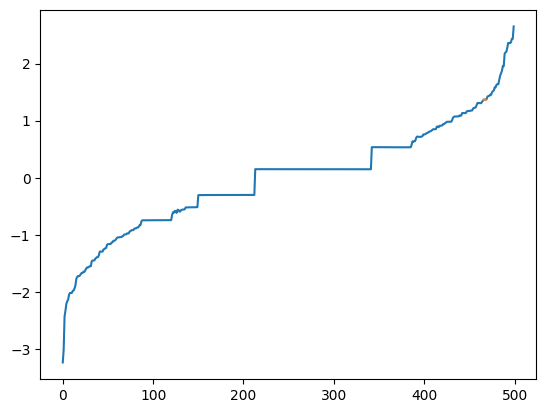

In [2082]:
plt.plot(avg_dtheta[-4])
plt.plot(c_,avg_dtheta[-4,c_])

In [1679]:
c_ = clusters[0]
print(len(c_))

12


In [2085]:
def cluster_os_new(avg_dtheta,N,cidx=False,threshold = 7e-3,s_threshold = 5,c_threshold =  1e-6):
    A = []
    for i in range(1500):
        arg = np.argsort(avg_dtheta[-i])
        temp = avg_dtheta[-i]
        temp = np.where(np.diff([temp[arg][0],*temp[arg]])
                        <threshold,0,temp[arg])
        A.append(temp)
    mean_A_index = np.where(np.sum(A,axis=0) ==  0,0,np.sum(A,axis=0)) #실제 클러스터의 값

    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    diff_avg_dtheta = np.diff(np.c_[avg_dtheta[:,arg[0]],avg_dtheta[:,arg]],axis=1)
    # plt.plot(mean_A_index)
    peaks, =  np.where(np.sum(A,axis=0) !=  0)

    try:
        peaks_new = np.array([peaks[0],*peaks,N])
        if len(peaks) == 1:
            peaks_new = np.array([peaks[0],N])
    except IndexError:
        peaks_new = np.array([0,N])

    psize = np.diff(peaks_new)
    arg_psize = np.argsort(psize)[::-1]
    clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
    c_size = np.array(list(map(len,clusters)))
    c_stability = []
    mean_omega = []
    if len(clusters)>0:
        for c_ in clusters:
            c_ = c_.astype(int)

            c_stability.append(abs(np.mean(diff_avg_dtheta[:,c_[1:]])/len(c_)))
            mean_omega.append(np.mean(avg_dtheta[:,c_]))
    c_stability = np.array(c_stability)
    mean_omega = np.array(mean_omega)

    const1 = abs(c_stability) < c_threshold 
    const2 = c_size > s_threshold
    Is_group, = np.where(const1 & const2)
    CM_S = c_size[Is_group]
    CM_O = mean_omega[Is_group]
    C_idx = np.array([np.sort(arg[clu.astype(int)]) for clu in clusters[Is_group]],dtype=object)
    if cidx == True:
        return CM_S,CM_O,C_idx,c_stability[Is_group]
    else:
        return CM_S,CM_O


In [1684]:
c_

array([351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362])

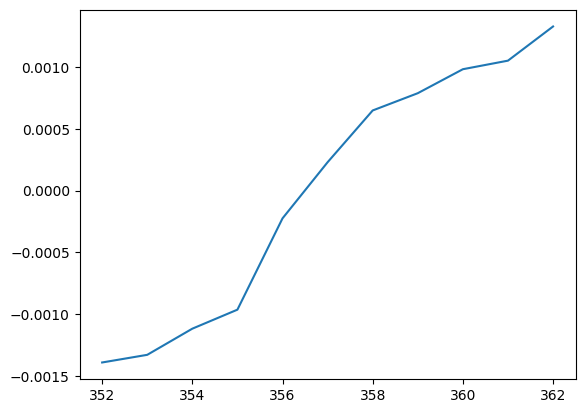

In [1687]:
mean_clu = np.mean(avg_dtheta[-1500,arg[c_[1:]]].T,axis=0)
plt.plot(c_[1:],avg_dtheta[-1500,arg[c_[1:]]] - mean_clu);

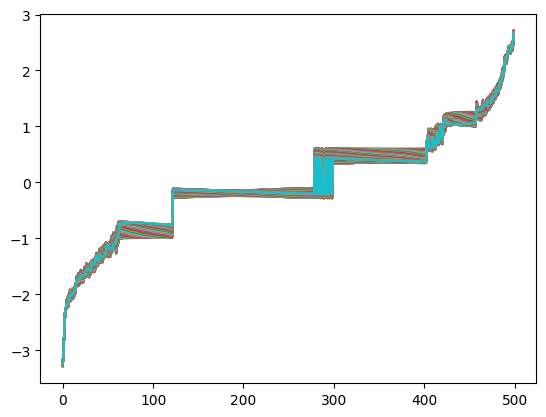

In [1646]:
plt.plot(dtheta_set[-100:,K_want].T);

In [1636]:
np.diff([[1,1,1,1],[2,2,2,2,]],axis=1)

array([[0, 0, 0],
       [0, 0, 0]])

In [1584]:
c_stability

array([1.14723921e-09, 5.54083143e-08, 1.73099126e-08, 5.56119965e-05,
       1.09247049e-04, 1.21996407e-04, 4.93808411e-06, 3.33089688e-05,
       3.01138052e-04, 5.80008274e-05])

In [1583]:
[print(len(c_))  for c_ in  clusters]

116
60
57
5
4
4
3
3
3
3


[None, None, None, None, None, None, None, None, None, None]

In [1477]:
avg_dtheta_set.shape

(2000, 100, 500)

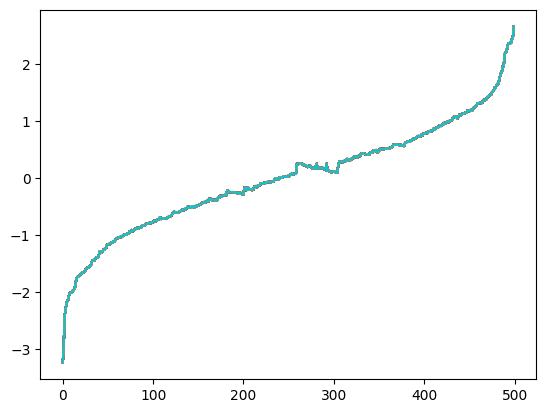

In [1544]:
plt.plot(dtheta_set[-100:,K_want,arg].T)

In [1454]:
c_stability[Is_group]

array([1.07806446e-10, 2.45092308e-05])

In [1412]:
C_idx

array([[356, 357, 358, 359, 360, 361],
       [193, 194, 195, 196, 197, 199]], dtype=object)

In [1392]:
c_stability

array([6.90736173e-13,            nan,            nan])

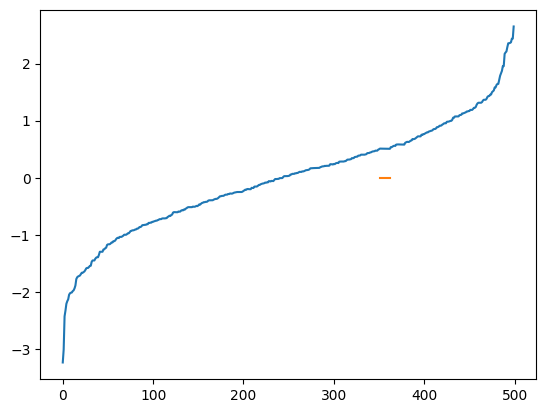

In [1723]:
plt.plot(avg_dtheta[-1])

for i,clu in enumerate(C_idx):
    plt.plot(clu,0.2*i*np.ones_like(clu))

In [1481]:
c_std , c_stability

([-4.367340253830225e-05,
  -7.692453700144251e-05,
  0.0002027658994908364,
  0.0001730077872824512,
  -4.11310016056198e-05,
  0.0003558962395616674,
  3.174150675914326e-05,
  -0.0002568811356845044,
  -0.00021188055733565396,
  -3.6351900500570797e-05],
 array([1.89884359e-06, 1.28207562e-05, 3.37943166e-05, 3.46015575e-05,
        8.22620032e-06, 1.18632080e-04, 1.05805023e-05, 8.56270452e-05,
        7.06268524e-05, 1.21173002e-05]))

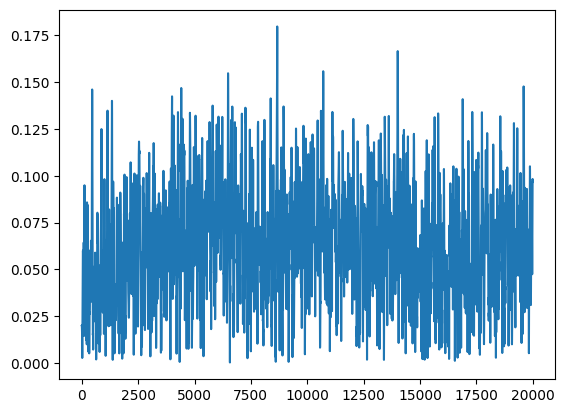

In [3272]:
plt.plot(rs.T[0][K_want])

In [1491]:
sum_time = 5000
rs_c = np.cumsum(rs.T[0].T,axis=0)
avg_rs = (rs_c[sum_time:] - rs_c[:-sum_time])/sum_time
# plt.plot(avg_rs)

In [1492]:
K_set[K_want]

array([1.9])

40


Text(0.5, 0.98, 'K = 4.00')

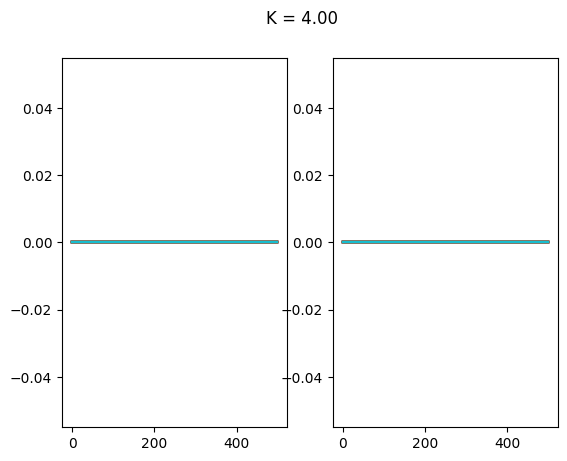

In [3353]:
K_ = 4
K_want = np.searchsorted(K_set.reshape(-1),K_)
mean_r = np.mean(rs.T[0][K_want][-sum_time:])
print(K_want)
plt.subplot(121)
plt.plot(np.sort(avg_dtheta_set[-100:,K_want]).T);
plt.subplot(122)
plt.plot(np.diff(np.sort(avg_dtheta_set[-100:,K_want]),axis=1).T)
plt.suptitle(f'K = {K_set.reshape(-1)[K_want]:.2f}')

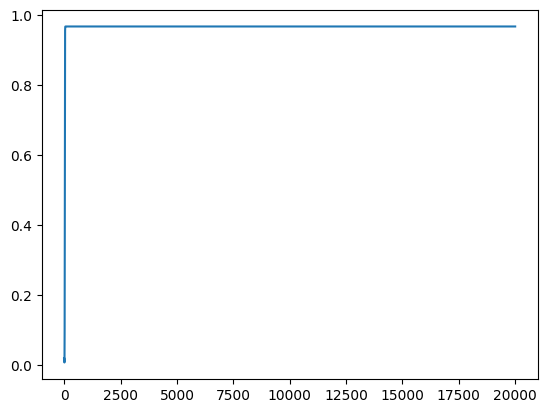

In [3354]:
plt.plot(rs.T[0][K_want])

[1.30972052e-12]
0


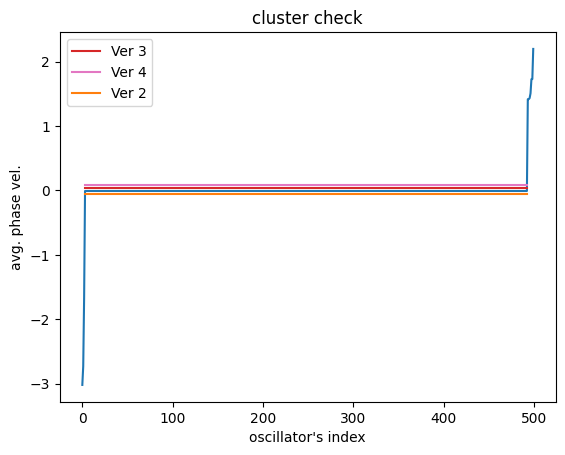

In [3387]:
i = K_want
avg_dtheta_ = avg_dtheta_set[:,i]
# CM_S,CM_O,C_idx,c_stability= cluster_os_new(avg_dtheta=avg_dtheta_,N=N,cidx=True,threshold = 4e-3,s_threshold = 5,c_threshold = 5e-7)
CM_S,CM_O,C_idx,c_stability= cluster_os_new(avg_dtheta=avg_dtheta_,N=N,cidx=True,threshold = 3e-2,s_threshold = 5,c_threshold = 5e-7)
print(c_stability)
plt.plot(avg_dtheta_[-1])

for i,(O,clu) in enumerate(zip(CM_O,C_idx)):
    if i == 0:
        plt.plot(clu,(O+0.05)*np.ones_like(clu),color='tab:red',label = 'Ver 3')
    else: plt.plot(clu,(O+0.05)*np.ones_like(clu),color='tab:red')
CS,CMP,cluster,omega_s,omega_e,check_ = cluster_os_new2(AVG=avg_dtheta_,check=1e-4)
for i,(O,clu) in enumerate(zip(CMP,cluster)):
    if i == 0:
        plt.plot(clu,(O+0.1)*np.ones_like(clu),color='tab:pink',label = 'Ver 4')
    else: plt.plot(clu,(O+0.1)*np.ones_like(clu),color='tab:pink')
# CM_S,CM_O,C_idx,check,psize_array,cluster_array,Is_group3 = cluster_os(avg_dtheta=avg_dtheta_,N=N,dt=dt,peak_height = 0.03,first_sensitivity=3e-3,second_sensitivity = 4e-3,cidx=True)
CM_S,CM_O,C_idx,check,psize_array,cluster_array,Is_group3 = cluster_os(avg_dtheta=avg_dtheta_,N=N,dt=dt,peak_height = 0.03,first_sensitivity=3e-3,second_sensitivity = 4e-3,cidx=True)
arg_O = np.argsort(CM_O)
arg_S = np.argsort(CM_S)[::-1]
print(check)
for i,(O,clu) in enumerate(zip(CM_O,C_idx)):
    if i == 0:
        plt.plot(clu,(O-0.05)*np.ones_like(clu),color='tab:orange',label = 'Ver 2')
    else: plt.plot(clu,(O-0.05)*np.ones_like(clu),color='tab:orange')
plt.title('cluster check')
plt.xlabel('oscillator\'s index')
plt.ylabel('avg. phase vel.')
plt.legend()

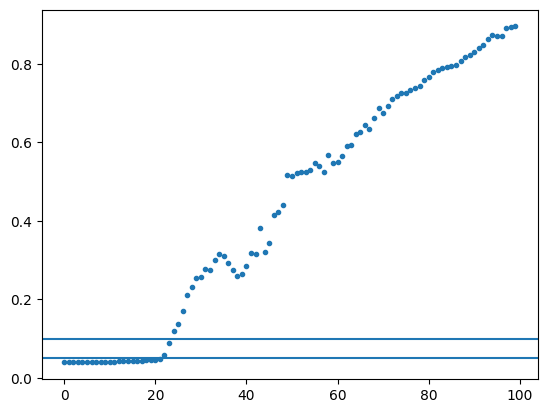

In [16]:
plt.plot(mean_rs,'.')
plt.axhline(0.1)
plt.axhline(0.05)

In [1276]:
CM_S[arg_S]

array([], dtype=float64)

In [1277]:
CM_O[arg_S]

array([], dtype=float64)

In [1278]:
CM_O
# CM_S

array([], dtype=float64)

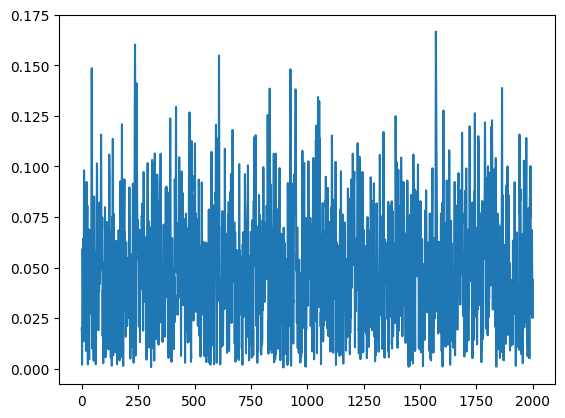

In [1425]:
plt.plot(t,rs.T[0].T[:,K_want])
# plt.ti

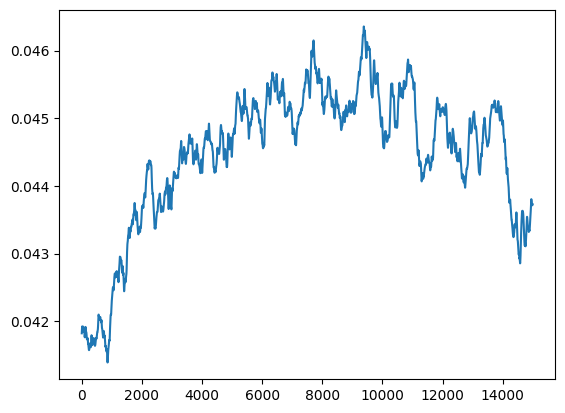

In [1280]:
plt.plot(avg_rs[:,K_want])

In [741]:
c_stability

array([ 1.10591153e-06,  8.74079122e-07,  3.15670906e-06,  1.00633433e-06,
        4.60217116e-04,  3.56473597e-04, -2.76248857e-04,  1.37652447e-03,
        3.17791930e-04,  6.16175447e-04])

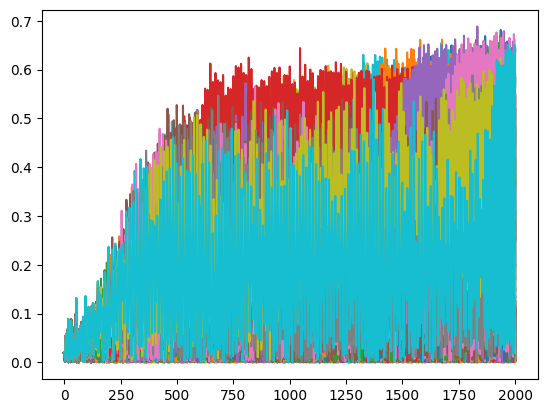

In [1558]:
plt.plot(t,rs.T[0].T);

In [743]:
K_set = np.arange(1,3,0.1).reshape(-1,1)
seed = 10
m = 10
N = 500
dm = 1
ms = np.arange(0,5+dm/2,dm)
# for m in ms:
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_init_set = (np.ones((N_set,1))*theta_init)
pdtheta_set = (np.ones((N_set,1))*omega)
omega_set = (np.ones((N_set,1))*omega)
r,rstd,rMM,CSO_set,check_set,avg_dtheta_set_last = C_rsmso_set(m,K_set,N,theta_init_set,omega_set,pdtheta_set,t_end=5000,dt=0.1)

ValueError: not enough values to unpack (expected 6, got 5)

In [3328]:
Ks[mean_rs>0.05]

array([2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4,
       3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ,
       6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6,
       8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

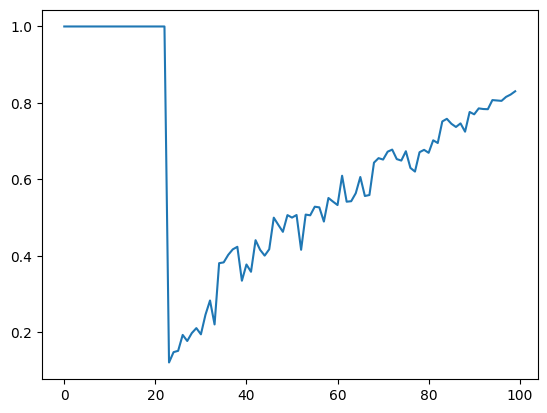

In [3326]:
plt.plot(np.where(mean_rs<0.1,1,mean_rs))

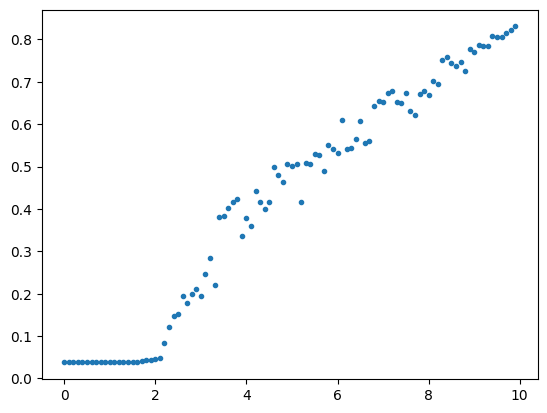

In [3327]:
plt.plot(K_set.reshape(-1),mean_rs,'.')

In [3319]:
mean_rs

array([  700.9109249 ,   699.77632853,   697.87105853,   699.10228123,
         707.55430949,   707.04161819,   712.84412262,   708.31361984,
         721.69830618,   726.61638454,   724.07497914,   730.52997857,
         729.13388466,   721.34138339,   729.37090403,   736.84875441,
         737.90196724,   748.01423646,   810.15053127,   814.27892181,
         837.80960396,   884.87075978,  1557.68340935,  2247.58563902,
        2747.67234111,  2810.95910944,  3580.16269731,  3286.99216632,
        3667.82812267,  3909.76816198,  3609.03759333,  4555.28134459,
        5245.68535808,  4088.16558579,  7050.92063346,  7088.96472876,
        7454.02579799,  7719.70385943,  7842.97103346,  6202.30112533,
        6987.35827448,  6635.03022744,  8162.46201714,  7695.53306817,
        7415.93951682,  7723.38108317,  9252.19564913,  8903.21517374,
        8566.58927332,  9376.21332138,  9255.90787713,  9380.28585508,
        7699.33443875,  9400.75638073,  9366.52690992,  9782.32195166,
      

In [3318]:
Ks[mean_rs>0.1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

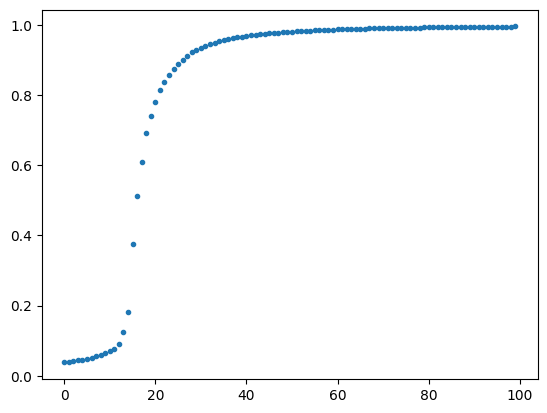

In [3382]:
plt.plot(mean_rs,'.')

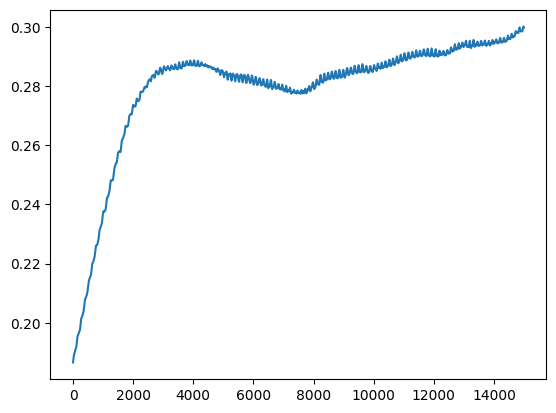

In [3381]:
plt.plot(avg_rs[:,K_want+5])

## **simulation check**

In [8]:
dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
CSO_set = []
check_set = [] 
cluster_set = []
Is_group_set = []
for i in range(N_set):
    CM_S,CM_O,C_idx,c_stability= cluster_os_new(avg_dtheta=avg_dtheta_set[:,i],N=N,cidx=True,threshold = 1e-4,s_threshold = 5,c_threshold = 6e-3)
    CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
    CSO_set.append(CSO)

NameError: name 'cluster_os_new' is not defined

In [14]:
dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
dtype2 = [('cluster size', int), ('cluster mean natural frequency', float)]
CSMP_set = []
CSMO_set = []
check_set = [] 
cluster_set = []
Is_group_set = []
c_threshold = np.where(mean_rs<0.1,1e-5,3e-4)
error_set = []
C_omega_s = []
C_omega_e = []
C_omega_m = []

Ks =K_set.reshape(-1)
for i in range(N_set):
    AVG = avg_dtheta_set[-1500:,i]
    c_check = c_threshold[i]
    try:
        CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e = cluster_os_new2(AVG=AVG,check=c_check,c_size=5,N=N)
        CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
        CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype2)
        CSMP_set.append(CSMP)
        CSMO_set.append(CSMO)
        error_set.append(np.nan)
        C_omega_s.append(omega_s)
        C_omega_e.append(omega_e)
    except ValueError:
        CS = []
        CMP = []
        CMO = []
        CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
        CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype)

        CSMP_set.append(CSMP)
        CSMO_set.append(CSMO)
        error_set.append(Ks[i])
        C_omega_s.append(np.nan)
        C_omega_e.append(np.nan)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_71386/1467307813.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster = np.array([np.arange(c_i,c_j,1) for c_i,c_j in zip(C_start[Is_group,-1],C_end[Is_group,-1])])


/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_71386/4172263514.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter([K]*len(omega_s),omega_s,vmin=0,vmax=10,color ='tab:red',alpha=0.5,zorder=0)
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_71386/4172263514.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter([K]*len(omega_e),omega_e,vmin=0,vmax=10,color ='tab:blue',alpha=0.5,zorder=1)


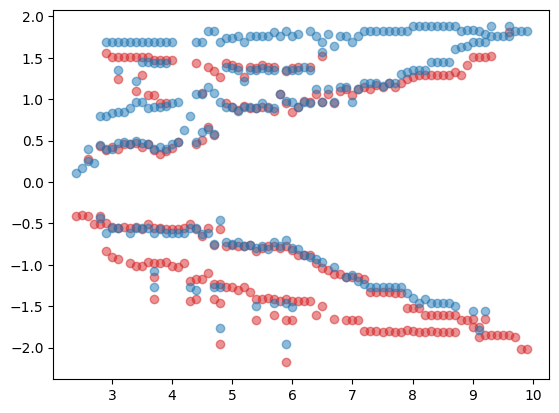

In [17]:
num = 0 
for K,omega_s,omega_e in zip(K_set.reshape(-1),C_omega_s,C_omega_e):
    plt.scatter([K]*len(omega_s),omega_s,vmin=0,vmax=10,color ='tab:red',alpha=0.5,zorder=0)
    plt.scatter([K]*len(omega_e),omega_e,vmin=0,vmax=10,color ='tab:blue',alpha=0.5,zorder=1)
# plt.xlim(2,3)

empty 2.1
empty 2.2
empty 2.3000000000000003
start 2.4000000000000004


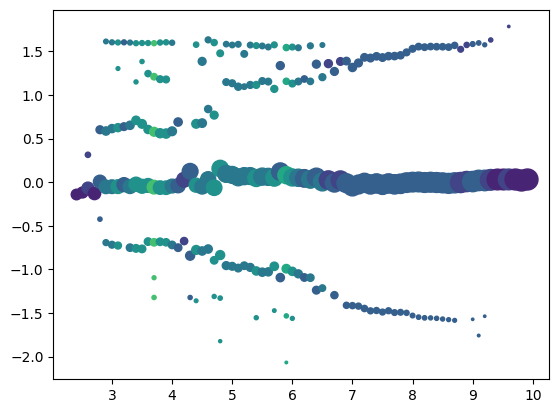

In [15]:
num = 0 
for K,CSO in zip(K_set.reshape(-1),CSMP_set):
    if (len(CSO) > 0)&(num==0):
        num +=1
        print('start',K)

    x = CSO['cluster mean phase velocity']
    s = CSO['cluster size']
    if (K>2)&(len(s)==0):
        print('empty',K)

    if (K<2)&(len(s)!=0):
        print('Nope',K)
    plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=10)
# plt.xlim(2,3)

In [3521]:
num = 0 
for K,CSO in zip(K_set.reshape(-1),CSMO_set):
    if (len(CSO) > 0)&(num==0):
        num +=1
        print('start',K)

    x = CSO['cluster mean phase velocity']
    s = CSO['cluster size']
    if (K>2)&(len(s)==0):
        print('empty',K)

    if (K<2)&(len(s)!=0):
        print('Nope',K)
    plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=10)
# plt.xlim(2,3)

empty 2.1
start 2.2
len 2 2.2
len 4 2.4000000000000004
len 4 2.5
len 3 2.6
len 4 2.7
len 3 2.8000000000000003
len 3 2.9000000000000004
empty 3.0
len 4 3.2
len 3 3.3000000000000003
len 5 3.4000000000000004
len 3 3.5
len 4 3.6
len 2 3.7
len 4 3.8000000000000003
len 3 3.9000000000000004
len 3 4.0
len 3 4.1000000000000005
len 2 4.2
len 3 4.3
len 3 4.4
len 4 4.5
len 4 4.6000000000000005
len 4 4.7
len 3 4.800000000000001
len 3 4.9
len 3 5.0
len 3 5.1000000000000005
len 3 5.2
len 4 5.300000000000001
len 4 5.4
len 3 5.5
len 3 5.6000000000000005
len 4 5.7
len 4 5.800000000000001
len 4 5.9
len 4 6.0
len 3 6.1000000000000005
len 4 6.2
len 4 6.300000000000001
len 3 6.4
len 5 6.5
len 3 6.6000000000000005
len 4 6.7
len 3 6.800000000000001
len 4 6.9
len 4 7.0
len 4 7.1000000000000005
len 3 7.2
len 4 7.300000000000001
len 4 7.4
len 4 7.5
len 3 7.6000000000000005
len 4 7.800000000000001
len 5 7.9
len 3 8.0
len 4 8.1
len 5 8.200000000000001
len 2 8.3
len 3 8.4
len 4 8.5
len 2 8.6
len 4 8.700000000000001

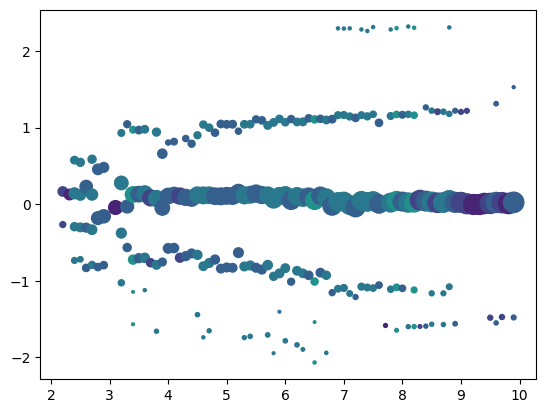

In [3330]:
num = 0 
for K,CSO in zip(K_set.reshape(-1),CSO_set):
    try:
        if (len(CSO) > 0)&(num==0):
            num +=1
            print('start',K)

        x = CSO['cluster mean phase velocity']
        s = CSO['cluster size']
        if (K>2)&(len(s)==0):
            print('empty',K)
        if (K>2)&(len(s)>1):
            print('len',len(s),K)
        if (K<2)&(len(s)!=0):
            print('Nope',K)
        plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=10)
    except ValueError:
        print('ValueError',K)
    # plt.xlim(2,3)

In [1]:
dK = 0.1
dm = 0.1
N = 500
seed = 11

theta_init,omega,Kc = Normal(N,0,1,seed=seed)
K_set = np.arange(0,5,dK).reshape(-1,1)

N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
ms = np.arange(0,10+dm/2,dm)
m_set = []
core = 8
index_ = 0
for i in range(len(ms)//core +1):
    m_set.append(ms[index_:index_+core])
    index_ += core
core_set = [len(ms) for ms in m_set]
N_set = len(K_set)
theta_init_set = (np.ones((N_set,1))*theta_init)
pdtheta_set = 0*(np.ones((N_set,1))*omega)
omega_set = (np.ones((N_set,1))*omega)

NameError: name 'Normal' is not defined

In [13]:
core_set

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5]

In [15]:
cols ={'r':[0],'rstd':[0],'rMM':[0],'check':[0]}
for i in range(10):
    cols[f'c{i}'] = np.nan
for i in range(10):
    cols[f'c{i} omega'] = np.nan

cols['K'] = K_set.reshape(-1)[0]
cols['m'] = ms[0]
df = pd.DataFrame(cols)
df_Km = df.set_index(['K','m'])

In [16]:
for core,ms in zip(core_set,m_set):
    for m,(r,rstd,rMM,CSO_set,check_set) in zip(ms,parmap.map(C_rsmso_set,ms,K_set=K_set,N=N,theta_init_set=theta_init_set,
                                                        omega_set=omega_set,pdtheta_set = pdtheta_set,t_end=2000,dt=0.01,
                                                        pm_pbar=True, pm_processes=core)):
        for i,K in enumerate(K_set.reshape(-1)):
            df_Km.loc[(K,m),"r"] = r[i]
            df_Km.loc[(K,m),"rstd"] = rstd[i]
            df_Km.loc[(K,m),"rMM"] = rMM[i]
            df_Km.loc[(K,m),'check'] = check_set[i]
            CSO = CSO_set[i]
            for i in range(len(CSO_set[i])):
                    df_Km.loc[(K,m),f'c{i}'] = CSO['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSO['cluster mean phase velocity'][i]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
K_set = np.arange(5,10+dK/2,dK).reshape(-1,1)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
ms = np.arange(0,10+dm/2,dm)
m_set = []
core = 8
index_ = 0
for i in range(len(ms)//core +1):
    m_set.append(ms[index_:index_+core])
    index_ += core
core_set = [len(ms) for ms in m_set]
N_set = len(K_set)
theta_init_set = (np.ones((N_set,1))*theta_init)
pdtheta_set = 0*(np.ones((N_set,1))*omega)
omega_set = (np.ones((N_set,1))*omega)
for core,ms in zip(core_set,m_set):
    for m,(r,rstd,rMM,CSO_set,check_set) in zip(ms,parmap.map(C_rsmso_set,ms,K_set=K_set,N=N,theta_init_set=theta_init_set,
                                                        omega_set=omega_set,pdtheta_set = pdtheta_set,t_end=2000,dt=0.01,
                                                        pm_pbar=True, pm_processes=core)):
        for i,K in enumerate(K_set.reshape(-1)):
            df_Km.loc[(K,m),"r"] = r[i]
            df_Km.loc[(K,m),"rstd"] = rstd[i]
            df_Km.loc[(K,m),"rMM"] = rMM[i]
            df_Km.loc[(K,m),'check'] = check_set[i]
            CSO = CSO_set[i]
            for i in range(len(CSO_set[i])):
                    df_Km.loc[(K,m),f'c{i}'] = CSO['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSO['cluster mean phase velocity'][i]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
df_Km

,,r,rstd,rMM,check,c0,c1,c2,c3,c4,c5,...,c0 omega,c1 omega,c2 omega,c3 omega,c4 omega,c5 omega,c6 omega,c7 omega,c8 omega,c9 omega
K,m,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.037467,0.020066,0.118610,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,0.0,0.039385,0.021303,0.121755,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,0.0,0.041601,0.022916,0.121747,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,0.0,0.044947,0.024328,0.142298,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,0.0,0.048034,0.023979,0.149513,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.6,10.0,0.806045,0.039134,0.199104,0.0,18.0,417.0,19.0,NaN,NaN,NaN,...,-1.545675,0.024133,1.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.7,10.0,0.817761,0.044441,0.208281,0.0,26.0,422.0,NaN,NaN,NaN,NaN,...,-1.476867,0.022690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.8,10.0,0.822440,0.043049,0.183922,0.0,25.0,424.0,NaN,NaN,NaN,NaN,...,-1.409773,0.019284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


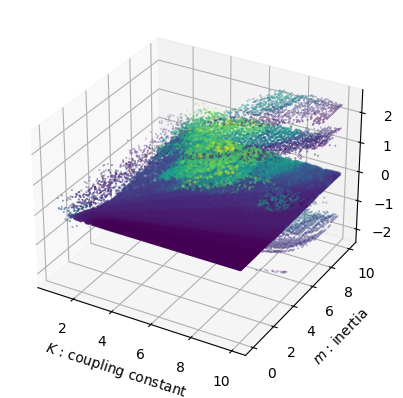

In [21]:
df = df_Km
KK = df.index.to_frame().K.unstack().to_numpy().T
MM = df.index.to_frame().m.unstack().to_numpy().T

Ks = df.reset_index().K
ms = df.reset_index().m
Ss_c0 = df.reset_index()['c0'].to_numpy()
Ss_c1 = df.reset_index()['c1'].to_numpy()
Ss_c2 = df.reset_index()['c2'].to_numpy()
Ss_c3 = df.reset_index()['c3'].to_numpy()
Ss_c4 = df.reset_index()['c4'].to_numpy()
Ss_c5 = df.reset_index()['c5'].to_numpy()
So_c0 = df.reset_index()['c0 omega'].to_numpy()
So_c1 = df.reset_index()['c1 omega'].to_numpy()
So_c2 = df.reset_index()['c2 omega'].to_numpy()
So_c3 = df.reset_index()['c3 omega'].to_numpy()
So_c4 = df.reset_index()['c4 omega'].to_numpy()
So_c5 = df.reset_index()['c5 omega'].to_numpy()

rMM = df.reset_index()['rMM']


# plt.subplot(projection='3d')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Ks,ms,So_c0,c=rMM,s=Ss_c0*0.01)
ax.scatter(Ks,ms,So_c1,c=rMM,s=Ss_c1*0.01)
ax.scatter(Ks,ms,So_c2,c=rMM,s=Ss_c2*0.01)
ax.scatter(Ks,ms,So_c3,c=rMM,s=Ss_c3*0.01)
ax.scatter(Ks,ms,So_c4,c=rMM,s=Ss_c4*0.01)
ax.scatter(Ks,ms,So_c5,c=rMM,s=Ss_c5*0.01)

ax.set_xlabel('$K$ : coupling constant')
ax.set_ylabel('$m$ : inertia')
ax.set_zlabel('cluster phase velocity')
# plt.zlim(-0.)
# plt.scatter(Ks,ms,Ss,Ss)
plt.show()


In [14]:
df

,,r,rstd,rMM,check,c0,c1,c2,c3,c4,c5,...,c0 omega,c1 omega,c2 omega,c3 omega,c4 omega,c5 omega,c6 omega,c7 omega,c8 omega,c9 omega
K,m,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.037467,0.020066,0.118610,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,0.0,0.039385,0.021303,0.121755,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,0.0,0.041601,0.022916,0.121747,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,0.0,0.044947,0.024328,0.142298,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,0.0,0.048034,0.023979,0.149513,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.6,10.0,0.806045,0.039134,0.199104,0.0,18.0,417.0,19.0,NaN,NaN,NaN,...,-1.545675,0.024133,1.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.7,10.0,0.817761,0.044441,0.208281,0.0,26.0,422.0,NaN,NaN,NaN,NaN,...,-1.476867,0.022690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.8,10.0,0.822440,0.043049,0.183922,0.0,25.0,424.0,NaN,NaN,NaN,NaN,...,-1.409773,0.019284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ms

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

array([0.1738235 , 0.16982386, 0.08754815, 0.17340487, 0.17861553,
       0.16532183, 0.16697293, 0.19482136, 0.15884662, 0.17410226,
       0.16709784, 0.13008259, 0.17171265, 0.17045531, 0.16110742,
       0.13786574, 0.16760652, 0.16574219, 0.12145744, 0.12108693,
       0.1254246 , 0.10595156, 0.10875747, 0.12614009, 0.12836547,
       0.11111106, 0.11880116, 0.12997421, 0.11436856, 0.10623526,
       0.11072306, 0.09539174, 0.10041654, 0.06889318, 0.06288578,
       0.06965988, 0.07488646, 0.06749376, 0.0765917 , 0.04924743,
       0.05318734, 0.04825818, 0.04573567, 0.05143502, 0.04536727,
       0.04566254, 0.03913443, 0.0444412 , 0.04304884, 0.04222076,
       0.02977731])

In [29]:
print(df_m.check.to_numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [1152]:
len(ms)

101

76
80
78
77
81
82
82
81
80
80


Text(0.5, 0, 'Coupling constant : $K$')

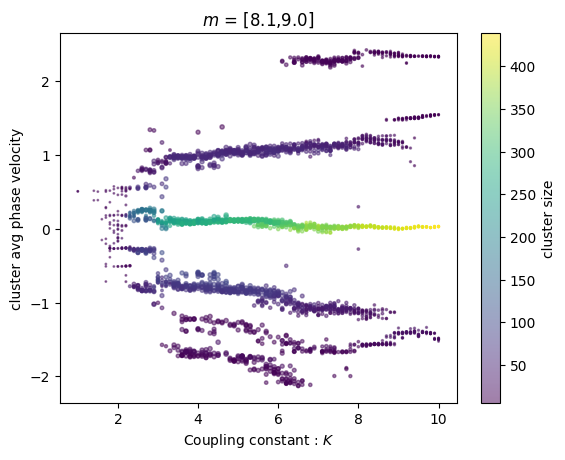

In [1175]:
m_i,m_end = 81,91
for i in range(m_i,m_end):
    m_idx = i
    ms = df.reset_index().m.unique()
    re_df = df.reset_index()

    df_m = re_df[re_df.m == ms[m_idx]]
    Ks = df_m.K.to_numpy()
    rs = df_m.r.to_numpy()
    rstd = df_m.rstd.to_numpy()
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]
    print(len(cluster_s['c1'].dropna()))
    plt.scatter(np.ones((10,101))*Ks,(cluster_o.to_numpy().T),c=cluster_s.to_numpy().T,alpha=0.5,
                s=50*np.ones((10,101))*rstd)
cbar = plt.colorbar()
cbar.set_label('cluster size')
plt.title(f'$m$ = [{ms[m_i]:.01f},{ms[m_end-1]:.01f}]')
plt.ylabel(r'cluster avg phase velocity')
plt.xlabel(r'Coupling constant : $K$')

In [ ]:
cbar.set_label()

In [24]:
# df_Km.sort_index().to_excel(f'N = {N} seed = {seed} test 230627.xlsm')
df_Km.sort_index().to_excel(f'N = {N} seed = {seed} test 230627 with initial phase vel.xlsm')

In [12]:
CSO_set

[array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity'

In [7]:
for CSO  in CSO_set:
    print(len(CSO['cluster size']),end = ' ')
for CSO  in CSO_set:
    print(CSO['cluster size'])


0 0 0 0 0 1 1 4 3 3 3 2 3 3 2 1 2 2 2 1 []
[]
[]
[]
[]
[217]
[255]
[ 17  73 279  51]
[ 73 292  51]
[ 36 355  39]
[ 42 342  48]
[ 39 355]
[ 23 382  41]
[ 17 409  20]
[414  19]
[430]
[ 17 443]
[ 17 446]
[ 17 448]
[456]


In [23]:
t_end=2000
dt=0.01
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets(K_set,m=m,N=N,t_array=t,
                                p_theta=theta_init_set,p_dtheta= pdtheta_set,p_omega=omega_set,
                                result_time = int((t_end)-(500))*int(1/dt)-1000)
if m == 0:
    dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)
N_set = len(theta_init_set)
r_duration = rs[-5000:,:]
r = np.mean(r_duration,axis=0).reshape(-1)
rstd = np.std(r_duration,axis=0).reshape(-1)
rMM = np.max(r_duration)-np.min(r_duration)
sum_time = 500*int(1/dt)
dtheta_c = np.cumsum(dtheta_set,axis=0)
avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

[0.] 1 0
[0.5] 1 0
[1.] 1 0
[1.5] 1 0
[2.] 1 0
[2.5] 0 1
[3.] 0 1
[3.5] 0 3
[4.] 0 3
[4.5] 0 2
[5.] 0 3
[5.5] 0 3
[6.] 0 2
[6.5] 0 3
[7.] 0 2
[7.5] 0 1
[8.] 0 1
[8.5] 0 2
[9.] 0 2
[9.5] 0 1


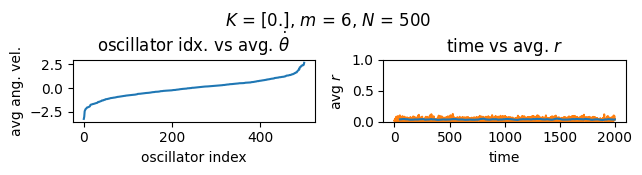

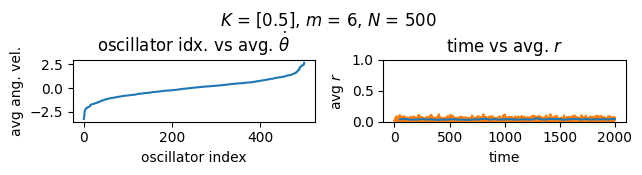

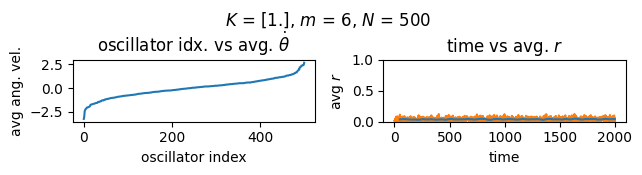

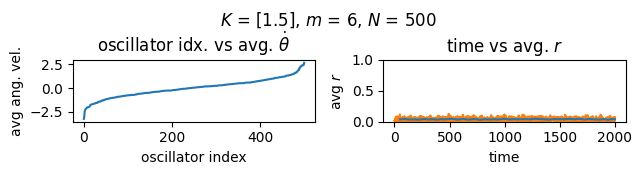

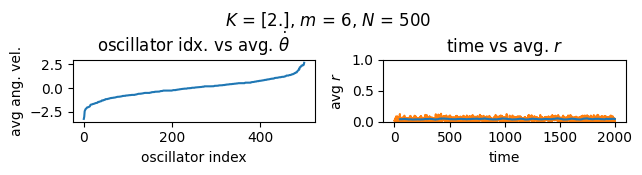

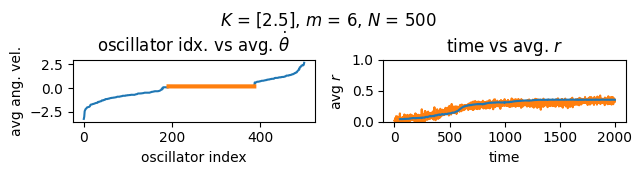

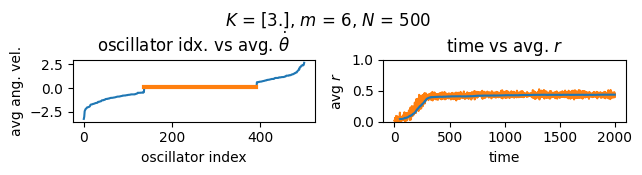

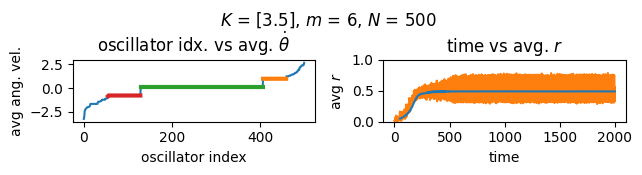

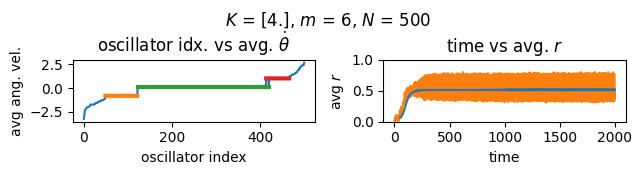

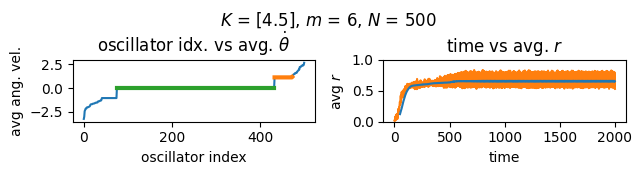

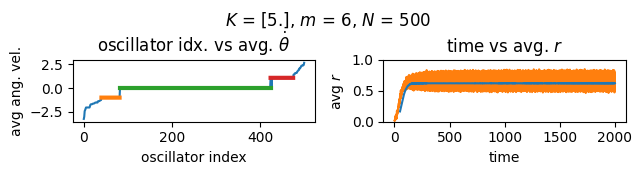

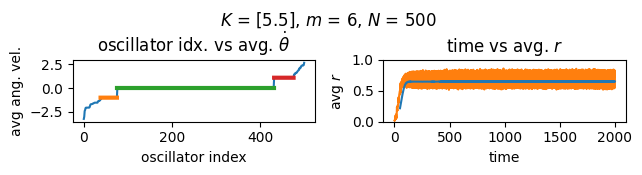

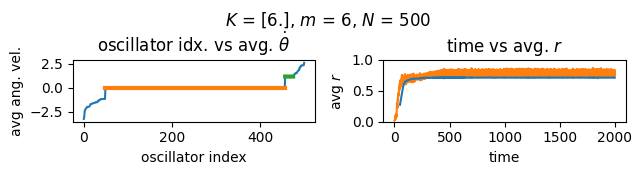

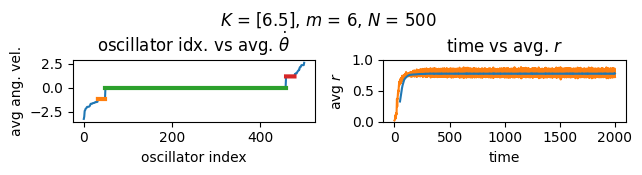

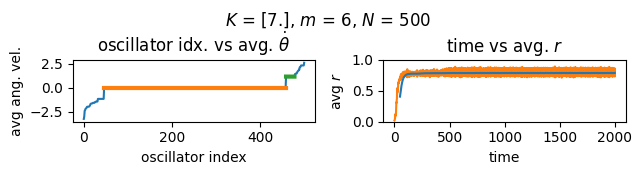

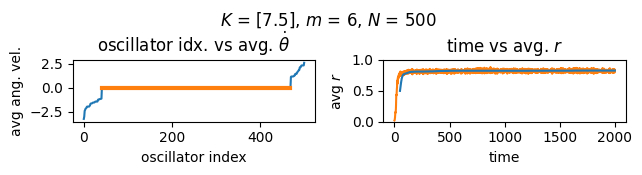

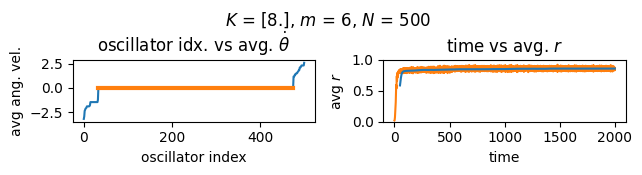

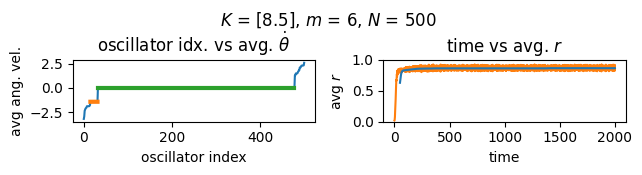

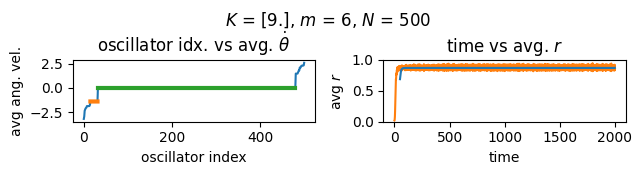

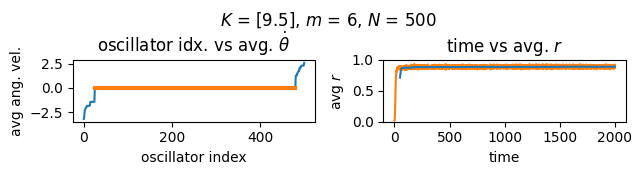

In [24]:
for i in range(N_set):
    avg_dtheta = avg_dtheta_set[:,i]
    CM_S,sCM_O,C_idx,check_,psize_array =cluster_os(avg_dtheta,N,cidx=True,dt=0.01)
    line_ = [np.polyfit(c_idx,avg_dtheta[-1][c_idx],1)[0] for c_idx in C_idx]
    K = K_set[i]
    avg_r = avg_r_set.T[i]
    r_ = rs.T[0][i]
    print(K,check_,len(line_))
    Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx)
    plt.plot(t,r_,zorder=0)

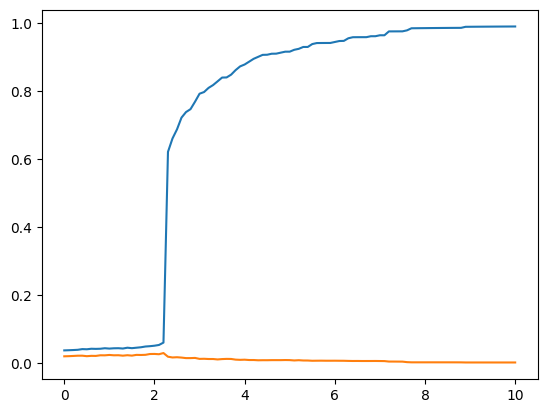

In [13]:
plt.plot(K_set.reshape(-1),r)
plt.plot(K_set.reshape(-1),rstd)

In [ ]:
def C_rsmso_set(m,K_set,N,theta_init_set,omega_set,pdtheta_set,t_end=5000,dt=0.1):
    t = np.arange(0,t_end,dt)
    _, dtheta_set,rs = mf2_sets(K_set,m=m,N=N,t_array=t,
                                p_theta=theta_init_set,p_dtheta= pdtheta_set,p_omega=omega_set,
                                result_time = int((t_end)-(200))*int(1/dt)-(150)*int(1/dt))

    if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)
    N_set = len(theta_init_set)
    r_duration = rs[-5000:,:]
    r = np.mean(r_duration,axis=0).reshape(-1)
    rstd = np.std(r_duration,axis=0).reshape(-1)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0)).reshape(-1)

    sum_time = 200*int(1/dt)
    if dt <= 0.01:
        sum_time = 2000
    dtheta_c = np.cumsum(dtheta_set,axis=0)
    avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    CSO_set = []
    check_set = [] 
    for i in range(N_set):
        CM_S,CM_O,check = cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt)
        CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
        CSO_set.append(CSO)
        check_set.append(check)
    return r,rstd,rMM,CSO_set,check_set

## **TO Algorithm**

In [3532]:
K_set = np.arange(0,10,0.1).reshape(-1,1)
seed = 10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
# theta_sets = (np.ones((N_set,1))*np.ones_like(theta_init))
omega_sets = (np.ones((N_set,1))*omega)


m = 10
t_end = 500
dt =0.01

def C_rsmso_set_new(m,K_set,N,theta_init_set,omega_set,pdtheta_set,t_end=5000,dt=0.1):
    t = np.arange(0,t_end,dt)
    omega = omega_set[0]
    theta_set, dtheta_set,rs = mf2_sets(K_set,N=N,m=m,t_array=t,
                                    p_theta=theta_init_set,p_dtheta= pdtheta_set,p_omega=omega_set,
                                    result_time = int((t_end)-(200))*int(1/dt)-(150)*int(1/dt))
    if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)
    sum_time = 1500
    dtheta_c = np.cumsum(dtheta_set,axis=0)
    avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    Ks = K_set.reshape(-1)
    r_duration = rs.T[0].T[-sum_time:]
    mean_rs = np.mean(r_duration,axis=0)
    mean_rs_std = np.std(r_duration,axis=0)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0)).reshape(-1)

    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    dtype2 = [('cluster size', int), ('cluster mean natural frequency', float)]
    CSMP_set = []
    CSMO_set = []
    check_set = [] 
    cluster_set = []
    C_s_set = []
    C_e_set = []
    c_threshold = np.where(mean_rs<0.1,1e-4,5e-4)
    error_set = []
    C_omega_s = []
    C_omega_e = []


    Ks =K_set.reshape(-1)
    for i in range(N_set):
        AVG = avg_dtheta_set[-1500:,i]
        c_check = c_threshold[i]
        try:
            CS,CMP,cluster,omega_s,omega_e,CMO,Is_group,C_s,C_e = cluster_os_new2(AVG=AVG,check=c_check,c_size=5,N=N,omega=omega)
            CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
            CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype2)
            CSMP_set.append(CSMP)
            CSMO_set.append(CSMO)
            error_set.append(np.nan)
            C_omega_s.append(omega_s)
            C_omega_e.append(omega_e)
            C_s_set.append(C_s)
            C_e_set.append(C_e)
        except ValueError:
            CS = []
            CMP = []
            CMO = []
            CSMP = np.array([(S,P) for S,P in zip(CS,CMP)],dtype=dtype)
            CSMO = np.array([(S,O) for S,O in zip(CS,CMO)],dtype=dtype)

            CSMP_set.append(CSMP)
            CSMO_set.append(CSMO)
            error_set.append(Ks[i])
            C_omega_s.append(np.nan)
            C_omega_e.append(np.nan)
            C_s_set.append([])
            C_e_set.append([])
    return mean_rs,mean_rs_std,CSMP_set,CSMO_set,error_set,C_s_set,C_e_set
# plt.legend()

In [3531]:
omega_sets[0].shape

(500,)

## **Algorithm check again**

In [3548]:
K_set = np.arange(0,10,0.1).reshape(-1,1)
seed = 10
N = 1000
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
# theta_sets = (np.ones((N_set,1))*np.ones_like(theta_init))
omega_sets = (np.ones((N_set,1))*omega)


m = 10
t_end = 2000
dt =0.1
t = np.arange(0,t_end,dt)

In [3549]:
mean_rs,mean_rs_std,CSMP_set,CSMO_set,error_set,C_s_set,C_e_set = C_rsmso_set_new(m,K_set,N,theta_sets,omega_sets,0*omega_sets,t_end=2000,dt=0.1)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_21503/1467307813.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster = np.array([np.arange(c_i,c_j,1) for c_i,c_j in zip(C_start[Is_group,-1],C_end[Is_group,-1])])


In [3552]:
e = np.array(error_set)
print(e[~np.isnan(e)])

[]


: 

In [ ]:
for K,c_s_set,c_e_set in  zip(K_set.reshape(-1),C_s_set,C_e_set):
    for c_s,c_e in zip(c_s_set,c_e_set):
        o = omega[c_s:c_e+1]
        plt.errorbar(K,np.mean(o),abs(np.max(o)-np.min(o)),fmt='.', capsize=3, capthick=1)

In [3544]:
c_e_set

[470, 39, 483]

empty 2.1
empty 2.2
empty 2.3000000000000003
start 2.4000000000000004
empty 5.6000000000000005


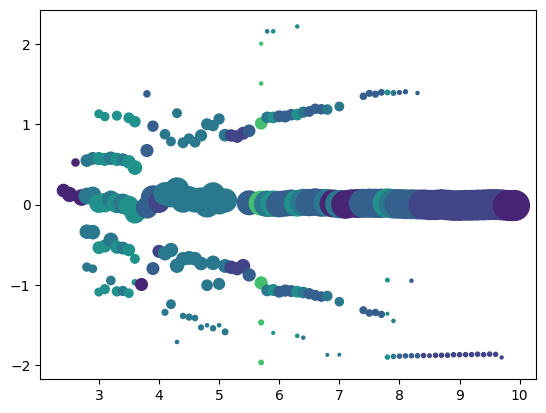

In [3550]:
num = 0 
# for K,CSO in zip(K_set.reshape(-1),CSMO_set):
#     if (len(CSO) > 0)&(num==0):
#         num +=1
#         print('start',K)

#     x = CSO['cluster mean natural frequency']
#     s = CSO['cluster size']
#     if (K>2)&(len(s)==0):
#         print('empty',K)

#     if (K<2)&(len(s)!=0):
#         print('Nope',K)
#     plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=10)

for K,CSO in zip(K_set.reshape(-1),CSMP_set):
    if (len(CSO) > 0)&(num==0):
        num +=1
        print('start',K)

    x = CSO['cluster mean phase velocity']
    s = CSO['cluster size']
    if (K>2)&(len(s)==0):
        print('empty',K)

    if (K<2)&(len(s)!=0):
        print('Nope',K)
    plt.scatter([K]*len(x),x,s=0.5*s,c=len(s)*np.ones_like(s),vmin=0,vmax=10)
# plt.xlim(2,3)

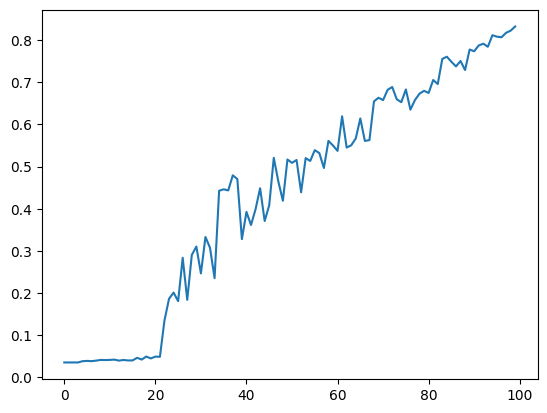

In [3538]:
plt.plot(mean_rs)

In [3485]:
r_duration.shape

(15000, 100)

In [ ]:
dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
CSO_set = []
check_set = [] 
cluster_set = []
Is_group_set = []
c_threshold = np.where(mean_rs<0.1,1e-4,5e-4)
error_set = []
Ks =K_set.reshape(-1)
for i in range(N_set):
    AVG = avg_dtheta_set[-1500:,i]
    c_check = c_threshold[i]
    try:
        CM_S,CM_O,C_idx,omega_s,omega_e,check = cluster_os_new2(AVG=AVG,check=c_check,c_size=5,N=N)
        CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
        CSO_set.append(CSO)
        error_set.append(np.nan)
    except ValueError:
        CM_S = []
        CM_O = []
        CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
        CSO_set.append(CSO)
        error_set.append(Ks[i])
print(error_set)